# JCC2 Questionnaire Master Analysis Notebook

This comprehensive notebook analyzes JCC2 User Questionnaire data across multiple dimensions:
- Application-Section effectiveness ratings
- User demographics and role analysis
- Sentiment analysis of qualitative feedback
- System usability and suitability evaluation
- Training and support effectiveness
- Comparative analysis across DCDC, CNMF, and COGUARD datasets

**Datasets**: DCDC, CNMF, COGUARD User Questionnaires

## Table of Contents

1. [Setup and Data Loading](#setup)
   - Data Collection Status Overview
2. [Application-Section Matrix Analysis](#app-section)
3. [User Demographics Analysis](#demographics)
4. [Sentiment Analysis of Feedback](#sentiment)
5. [System Usability and Suitability Analysis](#usability) ⚠️ **Data Missing**
6. [Training and Support Effectiveness](#training)
7. [Comparative Analysis Across Datasets](#comparative)
8. [Key Insights and Recommendations](#insights)

## 1. Setup and Data Loading <a id='setup'></a>

In [1]:
# System setup
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

# Import the processor module
from jcc2_data_processor import create_processor

# Data manipulation and analysis
import pandas as pd
import numpy as np
from datetime import datetime
import json
import re
from collections import Counter, defaultdict

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

# Professional tables
from great_tables import GT, md, html, loc, style

# Text analysis
from textblob import TextBlob
from wordcloud import WordCloud

# Statistical analysis
from scipy import stats
from scipy.stats import chi2_contingency, f_oneway

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Configure visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Define consistent color scheme
COLORS = {
    'primary': '#1f77b4',
    'secondary': '#ff7f0e',
    'tertiary': '#9467bd',
    'success': '#2ca02c',
    'danger': '#d62728',
    'warning': '#ff9800',
    'info': '#17a2b8',
    'gray': '#7f7f7f'
}

# Create output directory
output_dir = 'jcc2_master_analysis_output'
os.makedirs(output_dir, exist_ok=True)

print(f"Analysis started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Output directory: {output_dir}")

Analysis started at: 2025-08-03 21:17:38
Output directory: jcc2_master_analysis_output


In [2]:
# Load all datasets
data_files = {
  "DCDC": "/home/nathanjgaul/Development/projects/form_manager/data_analysis/data/real_world_data/DCDC UQ Combined_2025-07-30_pii_scrubbed.csv",
  "CNMF": "/home/nathanjgaul/Development/projects/form_manager/data_analysis/data/real_world_data/CNMF UQ Combined_2025-08-03_pii_scrubbed.csv",
  "COGUARD": "/home/nathanjgaul/Development/projects/form_manager/data_analysis/data/real_world_data/GOGUARD UQ Combined_2025-08-03_pii_scrubbed.csv"
}

# Initialize processors and dataframes
processors = {}
dataframes = {}
dataset_info = {}

for name, filepath in data_files.items():
    try:
        processors[name] = create_processor(filepath)
        dataframes[name] = processors[name].load_data()
        
        # Store dataset info
        dataset_info[name] = {
            'responses': len(dataframes[name]),
            'fields': len(dataframes[name].columns),
            'sections': len(processors[name].sections),
            'date_range': f"{dataframes[name]['user_information.date'].min()} to {dataframes[name]['user_information.date'].max()}"
            if 'user_information.date' in dataframes[name].columns else 'N/A'
        }
        
        print(f"\n{name} Dataset:")
        print(f"  - Responses: {dataset_info[name]['responses']}")
        print(f"  - Fields: {dataset_info[name]['fields']}")
        print(f"  - Sections: {dataset_info[name]['sections']}")
        print(f"  - Date range: {dataset_info[name]['date_range']}")
        
        # Debug: Print available sections
        print(f"  - Available sections: {list(processors[name].sections.keys())[:10]}...")
        
        # Debug: Look for basic_information fields
        basic_info_fields = [col for col in dataframes[name].columns if 'basic_information' in col.lower()]
        if basic_info_fields:
            print(f"  - Basic information fields found: {len(basic_info_fields)}")
            print(f"    Sample: {basic_info_fields[:5]}")
        
    except Exception as e:
        print(f"\nError loading {name}: {e}")

# Create combined dataset for collective analysis
combined_df = pd.concat(dataframes.values(), ignore_index=True)
print(f"\nCombined Dataset:")
print(f"  - Total Responses: {len(combined_df)}")
print(f"  - Total Fields: {len(combined_df.columns)}")

2025-08-03 21:17:38,317 - INFO - Detected User Questionnaire format
2025-08-03 21:17:38,318 - INFO - Loading data from /home/nathanjgaul/Development/projects/form_manager/data_analysis/data/real_world_data/DCDC UQ Combined_2025-07-30_pii_scrubbed.csv
2025-08-03 21:17:38,327 - INFO - Parsing field schemas
2025-08-03 21:17:38,337 - INFO - Loaded 21 data rows with 667 columns
2025-08-03 21:17:38,338 - INFO - Found 28 sections and 6 system columns
2025-08-03 21:17:38,454 - INFO - Detected User Questionnaire format
2025-08-03 21:17:38,455 - INFO - Loading data from /home/nathanjgaul/Development/projects/form_manager/data_analysis/data/real_world_data/CNMF UQ Combined_2025-08-03_pii_scrubbed.csv
2025-08-03 21:17:38,461 - INFO - Parsing field schemas
2025-08-03 21:17:38,469 - INFO - Loaded 6 data rows with 667 columns
2025-08-03 21:17:38,470 - INFO - Found 28 sections and 6 system columns
2025-08-03 21:17:38,485 - INFO - Detected User Questionnaire format
2025-08-03 21:17:38,485 - INFO - Load


DCDC Dataset:
  - Responses: 21
  - Fields: 667
  - Sections: 28
  - Date range: 2025-06-23 to 2025-06-25
  - Available sections: ['user_information', 'role_and_echelon', 'operational_jcc2_experience', 'jcc2_application_usage', 'mop_1_1_1', 'mos_1_1_2', 'mop_1_1_3', 'reporting_and_data_export', 'mop_1_1_5', 'mop_1_2_1']...

CNMF Dataset:
  - Responses: 6
  - Fields: 667
  - Sections: 28
  - Date range: 2025-06-26 to 2025-06-26
  - Available sections: ['user_information', 'role_and_echelon', 'operational_jcc2_experience', 'jcc2_application_usage', 'mop_1_1_1', 'mos_1_1_2', 'mop_1_1_3', 'reporting_and_data_export', 'mop_1_1_5', 'mop_1_2_1']...


2025-08-03 21:17:38,497 - INFO - Loaded 6 data rows with 667 columns
2025-08-03 21:17:38,497 - INFO - Found 28 sections and 6 system columns



COGUARD Dataset:
  - Responses: 6
  - Fields: 667
  - Sections: 28
  - Date range: 2025-06-30 to 2025-06-30
  - Available sections: ['user_information', 'role_and_echelon', 'operational_jcc2_experience', 'jcc2_application_usage', 'mop_1_1_1', 'mos_1_1_2', 'mop_1_1_3', 'reporting_and_data_export', 'mop_1_1_5', 'mop_1_2_1']...

Combined Dataset:
  - Total Responses: 33
  - Total Fields: 667


### Data Collection Status Overview

The following table shows which sections have data collected for each dataset:

In [3]:
# Generate Data Collection Status table
def create_data_collection_status_table():
    """Create a table showing which sections have data for each dataset"""
    
    # Define all major sections and their display names
    section_mapping = {
        'User Information': 'user_information',
        'Role and Echelon': 'role_and_echelon',
        'Operational JCC2 Experience': 'operational_jcc2_experience',
        'JCC2 Application Usage': 'jcc2_application_usage',
        'Application-Section Effectiveness': ['mop_1_1_1', 'mos_1_1_2', 'mop_1_1_3', 'mop_1_1_5', 
                                            'mop_1_2_1', 'mop_1_2_2', 'mos_1_3_1', 'mop_1_3_2', 
                                            'mop_1_3_3', 'mop_1_3_4', 'mop_1_3_5', 'mop_2_1_1', 
                                            'mop_2_1_2', 'mop_2_1_7', 'mop_2_1_9', 'mop_2_3_1', 
                                            'mop_2_3_2', 'mop_2_4_1', 'mos_3_2_1', 'mos_3_2_2', 
                                            'mop_3_2_3'],
        'Reporting and Data Export': 'reporting_and_data_export',
        'Training Effectiveness': 'mos_3_2_1',
        'Documentation Quality': 'mos_3_2_2',
        'Support Services': 'mop_3_2_3',
        'System Usability and Suitability Analysis': ['overall_system_usability', 'overall_system_suitability_eval'],
        'Overall System Effectiveness': 'overall_system_suitability_eval',
        'Text Feedback and Comments': ['mop_2_4_1', 'overall_system_suitability_eval']
    }
    
    # Check data availability for each section and dataset
    status_data = []
    
    for section_name, section_keys in section_mapping.items():
        row = {'Section': section_name}
        
        # Check each dataset
        for dataset_name, df in dataframes.items():
            has_data = False
            
            if isinstance(section_keys, list):
                # Check if any of the sections have data
                for key in section_keys:
                    # Check if any fields from this section exist and have data
                    section_fields = [col for col in df.columns if col.startswith(f"{key}.")]
                    if section_fields:
                        # Check if there's actual data (non-null values)
                        for field in section_fields:
                            if df[field].notna().any():
                                has_data = True
                                break
                    if has_data:
                        break
            else:
                # Single section key
                section_fields = [col for col in df.columns if col.startswith(f"{section_keys}.")]
                if section_fields:
                    # Check if there's actual data
                    for field in section_fields:
                        if df[field].notna().any():
                            has_data = True
                            break
            
            # Special check for System Usability and Suitability
            if section_name == 'System Usability and Suitability Analysis':
                # Check for the specific fields we expect
                usability_fields_check = ['overall_system_usability.like_to_use',
                                        'overall_system_usability.easy_to_use',
                                        'overall_system_suitability_eval.interoperability_data_integration']
                has_data = any(field in df.columns and df[field].notna().any() 
                             for field in usability_fields_check)
            
            row[dataset_name] = '✓' if has_data else ''
        
        status_data.append(row)
    
    # Create DataFrame
    status_df = pd.DataFrame(status_data)
    
    # Create great_table with fixed width
    status_table = (
        GT(status_df)
        .tab_header(
            title=md("**Data Collection Status by Dataset**"),
            subtitle=md("_Checkmarks indicate sections with collected data_")
        )
        .tab_style(
            style=[style.text(align="center")],
            locations=loc.body(columns=['DCDC', 'CNMF', 'COGUARD'])
        )
        .tab_style(
            style=[style.text(weight="bold"), style.fill(color="#f0f0f0")],
            locations=loc.column_labels()
        )
        .tab_style(
            style=[style.text(weight="bold")],
            locations=loc.body(columns=['Section'])
        )
        # Highlight the System Usability row that's missing data
        .tab_style(
            style=[style.fill(color="#ffe6e6")],
            locations=loc.body(
                rows=lambda df: df['Section'] == 'System Usability and Suitability Analysis'
            )
        )
        .tab_options(
            table_width="800px",  # Fixed width for PowerPoint
            table_font_size="11px",
            heading_title_font_size="16px",
            heading_subtitle_font_size="12px",
            data_row_padding="8px",
            column_labels_padding="8px"
        )
    )
    
    return status_table, status_df

# Create and display the status table
print("Creating Data Collection Status Table...")
collection_status_table, collection_status_df = create_data_collection_status_table()
display(collection_status_table)

# Save the table
collection_status_table.save(f'{output_dir}/data_collection_status.png', scale=2)

# Print summary of missing data
print("\nMissing Data Summary:")
for _, row in collection_status_df.iterrows():
    missing = [dataset for dataset in ['DCDC', 'CNMF', 'COGUARD'] if row[dataset] == '']
    if missing:
        print(f"  - {row['Section']}: Missing in {', '.join(missing)}")

# Special note about System Usability and Suitability
if all(collection_status_df[collection_status_df['Section'] == 'System Usability and Suitability Analysis'][dataset].values[0] == '' 
       for dataset in ['DCDC', 'CNMF', 'COGUARD']):
    print("\n⚠️  CRITICAL: System Usability and Suitability Analysis data is missing from ALL datasets!")
    print("   This suggests either:")
    print("   1. The questionnaire section was not completed by respondents")
    print("   2. The data export did not include these fields")
    print("   3. The field names have changed in the questionnaire")
    print("\n   Recommendation: Check the original questionnaire and data export process")

Creating Data Collection Status Table...


GT(_tbl_data=                                      Section DCDC CNMF COGUARD
0                            User Information    ✓    ✓       ✓
1                            Role and Echelon    ✓    ✓       ✓
2                 Operational JCC2 Experience    ✓    ✓       ✓
3                      JCC2 Application Usage    ✓    ✓       ✓
4           Application-Section Effectiveness    ✓    ✓       ✓
5                   Reporting and Data Export    ✓    ✓       ✓
6                      Training Effectiveness    ✓    ✓       ✓
7                       Documentation Quality    ✓    ✓       ✓
8                            Support Services    ✓    ✓       ✓
9   System Usability and Suitability Analysis    ✓    ✓       ✓
10               Overall System Effectiveness    ✓    ✓       ✓
11                 Text Feedback and Comments    ✓    ✓       ✓, _body=<great_tables._gt_data.Body object at 0x7268abff6810>, _boxhead=Boxhead([ColInfo(var='Section', type=<ColInfoTypeEnum.default: 1>, column_label='Section', column_align='left', column_width=None), ColInfo(var='DCDC', type=<ColInfoTypeEnum.default: 1>, column_label='DCDC', column_align='left', column_width=None), ColInfo(var='CNMF', type=<ColInfoTypeEnum.default: 1>, column_label='CNMF', column_align='left', column_width=None), ColInfo(var='COGUARD', type=<ColInfoTypeEnum.default: 1>, column_label='COGUARD', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7268ac525750>, _spanners=Spanners([]), _heading=Heading(title=Md(text='**Data Collection Status by Dataset**'), subtitle=Md(text='_Checkmarks indicate sections with collected data_'), preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns=['DCDC', 'CNMF', 'COGUARD'], rows=None, mask=None), grpname=None, colname='DCDC', rownum=0, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align='center', v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=['DCDC', 'CNMF', 'COGUARD'], rows=None, mask=None), grpname=None, colname='DCDC', rownum=1, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align='center', v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=['DCDC', 'CNMF', 'COGUARD'], rows=None, mask=None), grpname=None, colname='DCDC', rownum=2, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align='center', v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=['DCDC', 'CNMF', 'COGUARD'], rows=None, mask=None), grpname=None, colname='DCDC', rownum=3, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align='center', v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=['DCDC', 'CNMF', 'COGUARD'], rows=None, mask=None), grpname=None, colname='DCDC', rownum=4, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align='center', v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=['DCDC', 'CNMF', 'COGUARD'], rows=None, mask=None), grpname=None, colname='DCDC', rownum=5, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align='center', v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=['DCDC', 'CNMF', 'COGUARD'], rows=None, mask=None), grpname=None, colname='DCDC', rownum=6, colnum=None, styles=[CellStyleText(color=None, font=None, size=None, align='center', v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None)]), StyleInfo(locname=LocBody(columns=['DCDC', 'CNMF', 'COGUARD'], rows=None, mask=None


Missing Data Summary:


### Helper Functions

In [4]:
# Rating mappings and helper functions
rating_map = {
    'Completely Ineffective': 1,
    'Moderately Ineffective': 2,
    'Slightly Ineffective': 3,
    'Slightly Effective': 4,
    'Moderately Effective': 5,
    'Completely Effective': 6
}

# Agreement scale mapping
agreement_map = {
    'Strongly Disagree': 1,
    'Disagree': 2,
    'Somewhat Disagree': 3,
    'Somewhat Agree': 4,
    'Agree': 5,
    'Strongly Agree': 6
}

def calculate_rating_stats(series, mapping=rating_map):
    """Calculate statistics for a rating field"""
    valid_values = series.dropna()[~series.isin(['NA', 'N/A', 'Not Applicable'])]
    if len(valid_values) == 0:
        return None
    
    numeric_values = valid_values.map(mapping).dropna()
    if len(numeric_values) == 0:
        return None
    
    return {
        'mean': numeric_values.mean(),
        'median': numeric_values.median(),
        'std': numeric_values.std(),
        'min': numeric_values.min(),
        'max': numeric_values.max(),
        'count': len(numeric_values),
        'na_count': (series == 'Not Applicable').sum()
    }

def create_rating_distribution_plot(series, title, mapping=rating_map, figsize=(10, 6)):
    """Create a distribution plot for rating data"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Count plot
    value_counts = series.value_counts()
    order = ['Completely Ineffective', 'Moderately Ineffective', 'Slightly Ineffective',
             'Slightly Effective', 'Moderately Effective', 'Completely Effective', 'Not Applicable']
    order = [x for x in order if x in value_counts.index]
    
    value_counts.reindex(order, fill_value=0).plot(kind='bar', ax=ax1, color=COLORS['primary'])
    ax1.set_title(f'{title} - Response Distribution')
    ax1.set_xlabel('Rating')
    ax1.set_ylabel('Count')
    ax1.tick_params(axis='x', rotation=45)
    
    # Pie chart
    ax2.pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
    ax2.set_title(f'{title} - Response Percentage')
    
    plt.tight_layout()
    return fig

def export_to_excel(filename, sheets_dict):
    """Export multiple dataframes to Excel with formatting"""
    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        for sheet_name, df in sheets_dict.items():
            df.to_excel(writer, sheet_name=sheet_name[:31], index=True)  # Excel sheet names limited to 31 chars
    print(f"Exported to: {filename}")

## 2. Application-Section Matrix Analysis <a id='app-section'></a>

This section replicates and extends the application-section effectiveness rating analysis from the base notebook.

In [5]:
# Define sections and applications (from base notebook)
target_sections = [
    'mop_1_1_1', 'mos_1_1_2', 'mop_1_1_3', 'reporting_and_data_export',
    'mop_1_1_5', 'mop_1_2_1', 'mop_1_2_2', 'mos_1_3_1',
    'mop_1_3_2', 'mop_1_3_3', 'mop_1_3_4', 'mop_1_3_5',
    'mop_2_1_1', 'mop_2_1_2', 'mop_2_1_7', 'mop_2_1_9',
    'mop_2_3_1', 'mop_2_3_2', 'mop_2_4_1', 'mos_3_2_1',
    'mos_3_2_2', 'mop_3_2_3'
]

all_applications = [
    'a2it', 'cad', 'codex', 'crucible', 'cyber9line', 'dispatch',
    'jcc2cyberops', 'jcc2readiness', 'madss', 'rally', 'redmap',
    'sigact', 'threathub', 'triage', 'unity'
]

# Display names
app_display_names = {
    'a2it': 'A2IT', 'cad': 'CAD', 'codex': 'Codex',
    'crucible': 'Crucible', 'cyber9line': 'Cyber 9-Line',
    'dispatch': 'Dispatch', 'jcc2cyberops': 'JCC2 Cyber Ops',
    'jcc2readiness': 'JCC2 Readiness', 'madss': 'MADSS',
    'rally': 'Rally', 'redmap': 'REDMAP', 'sigact': 'SigAct',
    'threathub': 'Threat Hub', 'triage': 'Triage', 'unity': 'Unity'
}

section_display_names = {
    'mop_1_1_1': 'MOP 1.1.1', 'mos_1_1_2': 'MOS 1.1.2',
    'mop_1_1_3': 'MOP 1.1.3', 'reporting_and_data_export': 'Reporting & Export',
    'mop_1_1_5': 'MOP 1.1.5', 'mop_1_2_1': 'MOP 1.2.1',
    'mop_1_2_2': 'MOP 1.2.2', 'mos_1_3_1': 'MOS 1.3.1',
    'mop_1_3_2': 'MOP 1.3.2', 'mop_1_3_3': 'MOP 1.3.3',
    'mop_1_3_4': 'MOP 1.3.4', 'mop_1_3_5': 'MOP 1.3.5',
    'mop_2_1_1': 'MOP 2.1.1', 'mop_2_1_2': 'MOP 2.1.2',
    'mop_2_1_7': 'MOP 2.1.7', 'mop_2_1_9': 'MOP 2.1.9',
    'mop_2_3_1': 'MOP 2.3.1', 'mop_2_3_2': 'MOP 2.3.2',
    'mop_2_4_1': 'MOP 2.4.1', 'mos_3_2_1': 'MOS 3.2.1',
    'mos_3_2_2': 'MOS 3.2.2', 'mop_3_2_3': 'MOP 3.2.3'
}

In [6]:
# Helper function to check for rating fields
def normalize_for_comparison(lst):
    """Convert list to set, treating all NaN types as equivalent"""
    result = set()
    for item in lst:
        if pd.isna(item):
            result.add('__NaN__')
        else:
            result.add(item)
    return result

# Define standard rating values
rating_values = [
    'Completely Ineffective',
    'Moderately Ineffective',
    'Slightly Ineffective',
    'Slightly Effective',
    'Moderately Effective',
    'Completely Effective',
    'Not Applicable',
    float('nan'),
    np.nan
]

normalized_rating_set = normalize_for_comparison(rating_values)

In [7]:
# Import matrix generation functions from base notebook logic
# (These functions are simplified versions of the base notebook functions)

def get_app_from_field(field_name, section_prefix=""):
    """Extract app name from field"""
    if section_prefix and field_name.startswith(section_prefix):
        field_without_section = field_name[len(section_prefix):].lstrip(".")
    else:
        field_without_section = field_name
    
    for app in all_applications:
        if (field_without_section.endswith(app) or 
            field_without_section.endswith(f"_{app}") or
            field_without_section.endswith(f"-{app}")):
            return app
    return None

def calculate_field_rating(field_name, df):
    """Calculate average rating for a field"""
    if field_name not in df.columns:
        return None, 0, 0
    
    values = df[field_name]
    na_count = values.isin(['NA', 'N/A', 'Not Applicable']).sum()
    valid_mask = values.notna() & ~values.isin(['NA', 'N/A', 'Not Applicable'])
    valid_values = values[valid_mask]
    
    if len(valid_values) == 0:
        return None, na_count, len(values) - values.isna().sum()
    
    numeric_values = valid_values.map(rating_map).dropna()
    if len(numeric_values) == 0:
        return None, na_count, len(values) - values.isna().sum()
    
    return numeric_values.mean(), na_count, len(values) - values.isna().sum()

def create_rating_matrix(df, processor, dataset_name="Dataset"):
    """Create a rating matrix for a specific dataset"""
    
    print(f"\nCreating matrix for: {dataset_name}")
    print("=" * 80)
    
    # First, analyze sections for this dataset
    section_field_analysis = {}
    
    for section in target_sections:
        if section in processor.sections:
            fields = processor.sections[section]
            field_analysis = {
                "total_fields": len(fields),
                "app_specific_fields": {},
                "overall_fields": [],
            }

            # Identify rating fields
            rating_fields = [
                field
                for field in fields
                if not df[field].apply(lambda x: isinstance(x, list)).any()
                and not normalize_for_comparison(df[field].unique()) - normalized_rating_set
            ]

            for field in rating_fields:
                app_found = False
                field_lower = field.lower()
                
                # Check for app-specific field
                detected_app = get_app_from_field(field, section_prefix=f"{section}")
                if detected_app:
                    if detected_app not in field_analysis["app_specific_fields"]:
                        field_analysis["app_specific_fields"][detected_app] = []
                    field_analysis["app_specific_fields"][detected_app].append(field)
                    app_found = True
                elif field == "mop_2_4_1.mission_progress_assessment":
                    detected_app = "jcc2cyberops"
                    if detected_app not in field_analysis["app_specific_fields"]:
                        field_analysis["app_specific_fields"][detected_app] = []
                    field_analysis["app_specific_fields"][detected_app].append(field)
                    app_found = True

                # If not app-specific, it's likely an overall field
                if not app_found:
                    if "overall" in field_lower:
                        field_analysis["overall_fields"].append(field)
                    else:
                        field_analysis["overall_fields"].append(field)

            section_field_analysis[section] = field_analysis
    
    # Create the rating matrix
    matrix_data = []
    row_labels = []

    # Process each application
    for app in all_applications:
        row_data = []
        row_labels.append(app_display_names.get(app, app))
        
        for section in target_sections:
            if section not in section_field_analysis:
                row_data.append('x')
                continue

            # Check if this app has fields in this section
            app_fields = section_field_analysis[section]['app_specific_fields'].get(app, [])
            
            if not app_fields:
                row_data.append('x')
            else:
                # Calculate average rating for all app-specific fields
                ratings = []
                total_responses = 0
                na_responses = 0
                
                for field in app_fields:
                    rating, na_count, total_count = calculate_field_rating(field, df)
                    if rating is not None:
                        ratings.append(rating)
                    total_responses += total_count
                    na_responses += na_count
                
                if ratings:
                    avg_rating = np.mean(ratings)
                    row_data.append(f"{avg_rating:.1f}")
                elif na_responses > 0 and na_responses == total_responses:
                    row_data.append('N/A')
                else:
                    row_data.append('*')
        
        matrix_data.append(row_data)
    
    # Create DataFrame
    column_labels = [section_display_names.get(s, s) for s in target_sections]
    matrix_df = pd.DataFrame(matrix_data, index=row_labels, columns=column_labels)
    
    return matrix_df, matrix_data, row_labels, column_labels

In [8]:
# Generate matrices for all datasets
print("Generating Application-Section Matrices...\n")

all_matrices = {}
matrix_stats = {}

for dataset_name, df in dataframes.items():
    processor = processors[dataset_name]
    matrix_df, matrix_data, row_labels, column_labels = create_rating_matrix(df, processor, dataset_name)
    all_matrices[dataset_name] = matrix_df
    
    # Calculate statistics
    ratings = []
    for row in matrix_data:
        for val in row:
            try:
                ratings.append(float(val))
            except:
                pass

    if ratings:
        matrix_stats[dataset_name] = {
            'mean': np.mean(ratings),
            'std': np.std(ratings),
            'median': np.median(ratings),
            'min': min(ratings),
            'max': max(ratings)
        }
    
    print(f"{dataset_name} Matrix Generated:")
    print(f"  - Mean Rating: {matrix_stats[dataset_name]['mean']:.2f}")
    print(f"  - Std Dev: {matrix_stats[dataset_name]['std']:.2f}")
    print(f"  - Range: {matrix_stats[dataset_name]['min']:.1f} - {matrix_stats[dataset_name]['max']:.1f}\n")

Generating Application-Section Matrices...


Creating matrix for: DCDC
DCDC Matrix Generated:
  - Mean Rating: 3.34
  - Std Dev: 0.92
  - Range: 1.0 - 5.5


Creating matrix for: CNMF
CNMF Matrix Generated:
  - Mean Rating: 4.66
  - Std Dev: 0.75
  - Range: 3.2 - 5.5


Creating matrix for: COGUARD
COGUARD Matrix Generated:
  - Mean Rating: 5.05
  - Std Dev: 0.62
  - Range: 3.0 - 6.0



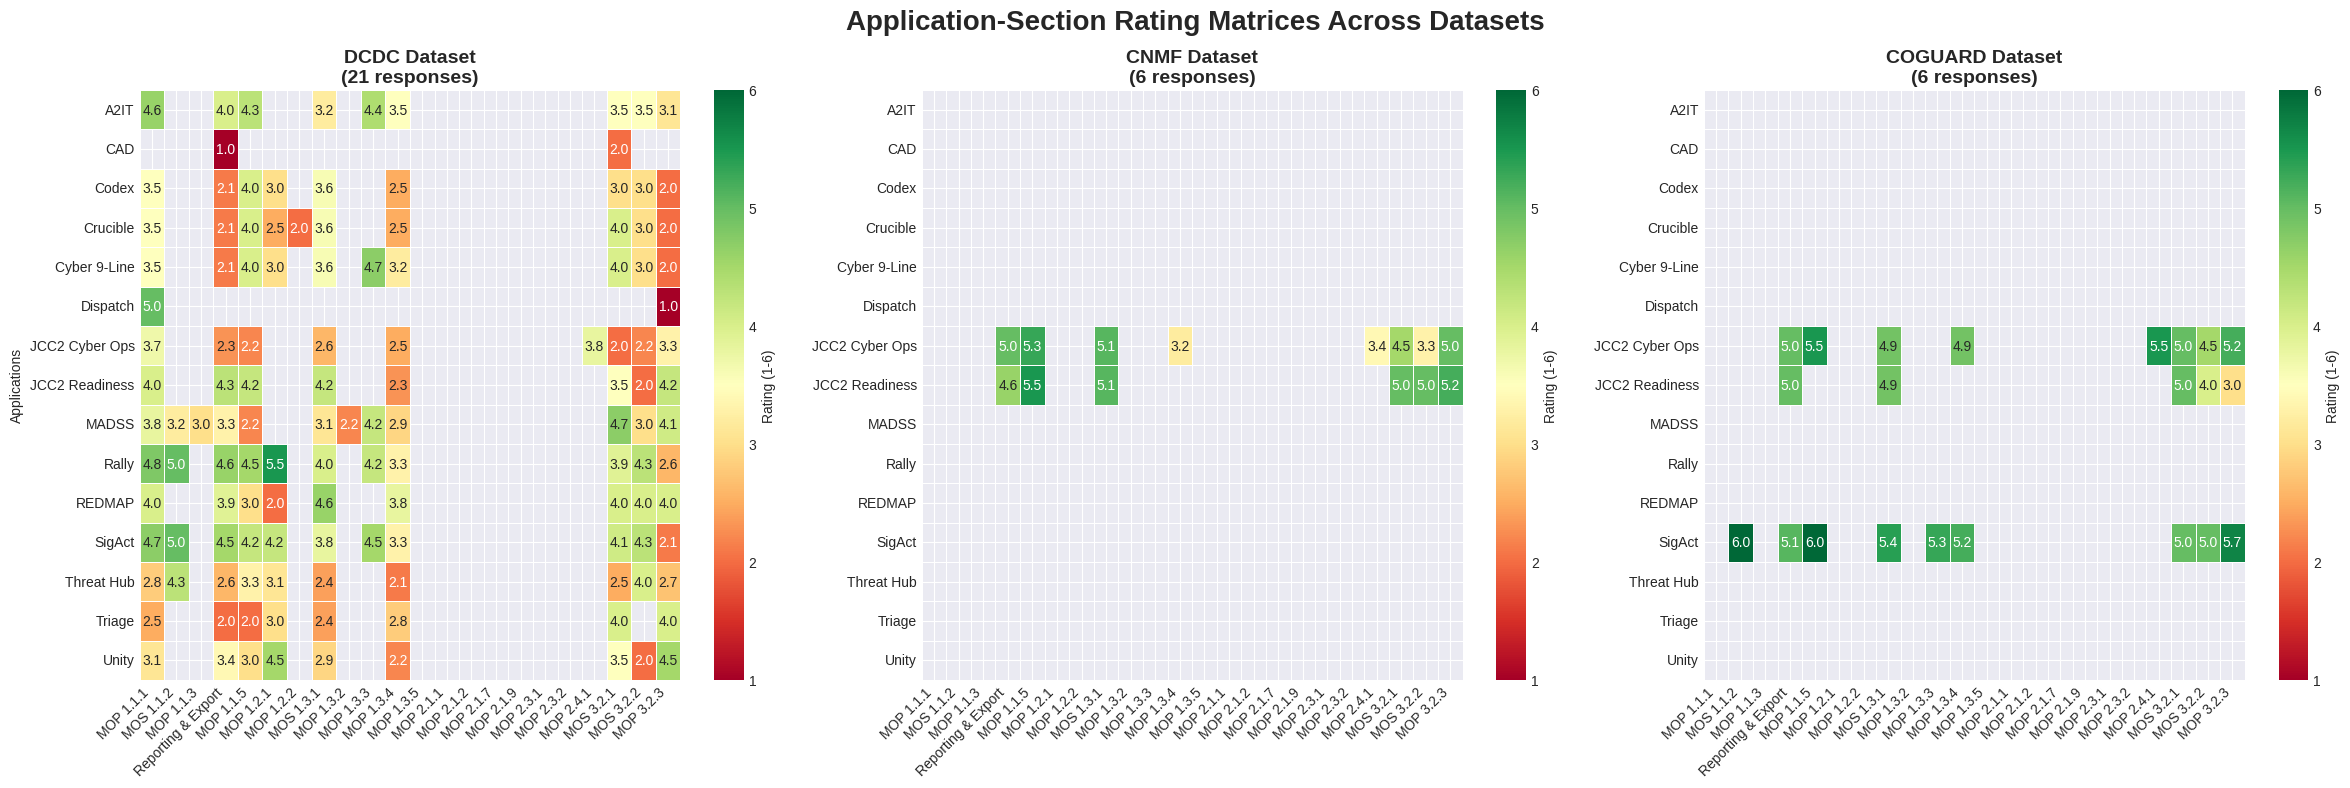

In [9]:
# Create comparative visualization
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
fig.suptitle('Application-Section Rating Matrices Across Datasets', fontsize=20, fontweight='bold')

for idx, (dataset_name, matrix_df) in enumerate(all_matrices.items()):
    ax = axes[idx]
    
    # Convert to numeric for heatmap
    numeric_matrix = matrix_df.copy()
    for col in numeric_matrix.columns:
        numeric_matrix[col] = pd.to_numeric(numeric_matrix[col], errors='coerce')
    
    # Create heatmap
    sns.heatmap(numeric_matrix, annot=matrix_df.values, fmt='', 
                cmap='RdYlGn', vmin=1, vmax=6, 
                cbar_kws={'label': 'Rating (1-6)'}, 
                ax=ax, linewidths=0.5)
    
    ax.set_title(f'{dataset_name} Dataset\n({dataset_info[dataset_name]["responses"]} responses)', 
                 fontsize=14, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Applications' if idx == 0 else '')
    
    # Rotate labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.savefig(f'{output_dir}/application_section_matrices_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. User Demographics Analysis <a id='demographics'></a>

Analyzing user roles, experience levels, and their correlation with effectiveness ratings.

In [10]:
# First, let's discover the actual demographic field names
print("Discovering demographic fields...")

# Look for basic_information section fields in the first dataset
if dataframes:
    sample_df = list(dataframes.values())[0]
    sample_processor = list(processors.values())[0]
    
    # Check if basic_information section exists
    if 'basic_information' in sample_processor.sections:
        basic_fields = sample_processor.sections['basic_information']
        print(f"\nBasic Information fields found: {len(basic_fields)}")
        for field in basic_fields[:20]:  # Show first 20 fields
            print(f"  - {field}")
    
    # Also search for fields by keywords
    role_fields = [col for col in sample_df.columns if any(x in col.lower() for x in ['role', 'position', 'title'])]
    cyber_fields = [col for col in sample_df.columns if 'cyber' in col.lower() and 'operator' in col.lower()]
    echelon_fields = [col for col in sample_df.columns if 'echelon' in col.lower()]
    duty_fields = [col for col in sample_df.columns if any(x in col.lower() for x in ['duty', 'duties', 'perform'])]
    exp_fields = [col for col in sample_df.columns if any(x in col.lower() for x in ['experience', 'years', 'time'])]
    
    print(f"\nFields found by keyword search:")
    print(f"  Role-related: {role_fields[:5]}")
    print(f"  Cyber operator: {cyber_fields[:5]}")
    print(f"  Echelon: {echelon_fields[:5]}")
    print(f"  Duties: {duty_fields[:5]}")
    print(f"  Experience: {exp_fields[:5]}")

# Update demographic fields based on discovery
# These will be updated after we see the actual field names
demographic_fields = {
    'role': None,
    'cyber_operator': None,
    'echelon': None,
    'duties': None,
    'experience': None
}

# Function to analyze demographics for a dataset
def analyze_demographics(df, dataset_name):
    """Analyze demographic distribution for a dataset"""
    print(f"\n{'='*60}")
    print(f"Demographics Analysis: {dataset_name}")
    print(f"{'='*60}")
    
    demographics_data = {}
    
    # First try to find the actual field names
    for demo_name in ['role', 'cyber_operator', 'echelon', 'duties', 'experience']:
        field = demographic_fields.get(demo_name)
        
        if field and field in df.columns:
            # Get value counts
            value_counts = df[field].value_counts(dropna=False)
            demographics_data[demo_name] = value_counts
            
            print(f"\n{demo_name.upper()} Distribution:")
            for value, count in value_counts.items():
                percentage = (count / len(df)) * 100
                print(f"  {value}: {count} ({percentage:.1f}%)")
        else:
            print(f"\n{demo_name.upper()}: Field not found or not mapped")
    
    return demographics_data

# We'll run the analysis after discovering the correct field names
all_demographics = {}

Discovering demographic fields...

Fields found by keyword search:
  Role-related: ['role_and_echelon.current_role_status', 'role_and_echelon.is_cyber_operator', 'role_and_echelon.cyber_ops_division_team', 'role_and_echelon.echelon', 'role_and_echelon.duties']
  Cyber operator: ['role_and_echelon.is_cyber_operator']
  Echelon: ['role_and_echelon.current_role_status', 'role_and_echelon.is_cyber_operator', 'role_and_echelon.cyber_ops_division_team', 'role_and_echelon.echelon', 'role_and_echelon.duties']
  Duties: ['role_and_echelon.duties', 'role_and_echelon.other_duties', 'overall_system_suitability_eval.performance', 'overall_system_suitability_eval.performance_details']
  Experience: ['operational_jcc2_experience.exp_cyberoperations', 'operational_jcc2_experience.exp_yourcurrentrole', 'operational_jcc2_experience.exp_jcc2experience', 'operational_jcc2_experience.exp_app_a2it', 'operational_jcc2_experience.exp_app_cad']


In [11]:
# Now update the demographic fields based on what we found
# The actual field names use different section names
demographic_fields = {
    'role': 'role_and_echelon.current_role_status',
    'cyber_operator': 'role_and_echelon.is_cyber_operator',
    'cyber_division': 'role_and_echelon.cyber_ops_division_team',
    'echelon': 'role_and_echelon.echelon',
    'duties': 'role_and_echelon.duties',
    'other_duties': 'role_and_echelon.other_duties',
    'cyber_ops_exp': 'operational_jcc2_experience.exp_cyberoperations',
    'current_role_exp': 'operational_jcc2_experience.exp_yourcurrentrole',
    'jcc2_exp': 'operational_jcc2_experience.exp_jcc2experience'
}

# Check if these fields exist and update mapping
print("\nVerifying demographic field mapping...")
fields_found = {}
for demo_name, field_name in demographic_fields.items():
    exists_in_any = False
    for dataset_name, df in dataframes.items():
        if field_name in df.columns:
            exists_in_any = True
            fields_found[demo_name] = field_name
            print(f"✓ {demo_name}: '{field_name}' found in {dataset_name}")
            break
    if not exists_in_any:
        print(f"✗ {demo_name}: '{field_name}' not found in any dataset")

# Update demographic_fields to only include found fields
demographic_fields = fields_found

# Analyze demographics for each dataset with the corrected field names
all_demographics = {}
for dataset_name, df in dataframes.items():
    all_demographics[dataset_name] = analyze_demographics(df, dataset_name)


Verifying demographic field mapping...
✓ role: 'role_and_echelon.current_role_status' found in DCDC
✓ cyber_operator: 'role_and_echelon.is_cyber_operator' found in DCDC
✓ cyber_division: 'role_and_echelon.cyber_ops_division_team' found in DCDC
✓ echelon: 'role_and_echelon.echelon' found in DCDC
✓ duties: 'role_and_echelon.duties' found in DCDC
✓ other_duties: 'role_and_echelon.other_duties' found in DCDC
✓ cyber_ops_exp: 'operational_jcc2_experience.exp_cyberoperations' found in DCDC
✓ current_role_exp: 'operational_jcc2_experience.exp_yourcurrentrole' found in DCDC
✓ jcc2_exp: 'operational_jcc2_experience.exp_jcc2experience' found in DCDC

Demographics Analysis: DCDC

ROLE Distribution:
  Contractor: 7 (33.3%)
  DoD Civilian: 7 (33.3%)
  Active Duty: 7 (33.3%)

CYBER_OPERATOR Distribution:
  Yes: 17 (81.0%)
  No: 4 (19.0%)

ECHELON Distribution:
  ['Operational']: 12 (57.1%)
  ['Operational', 'Tactical']: 2 (9.5%)
  ['Strategic']: 2 (9.5%)
  ['Strategic', 'Operational']: 2 (9.5%)
  [

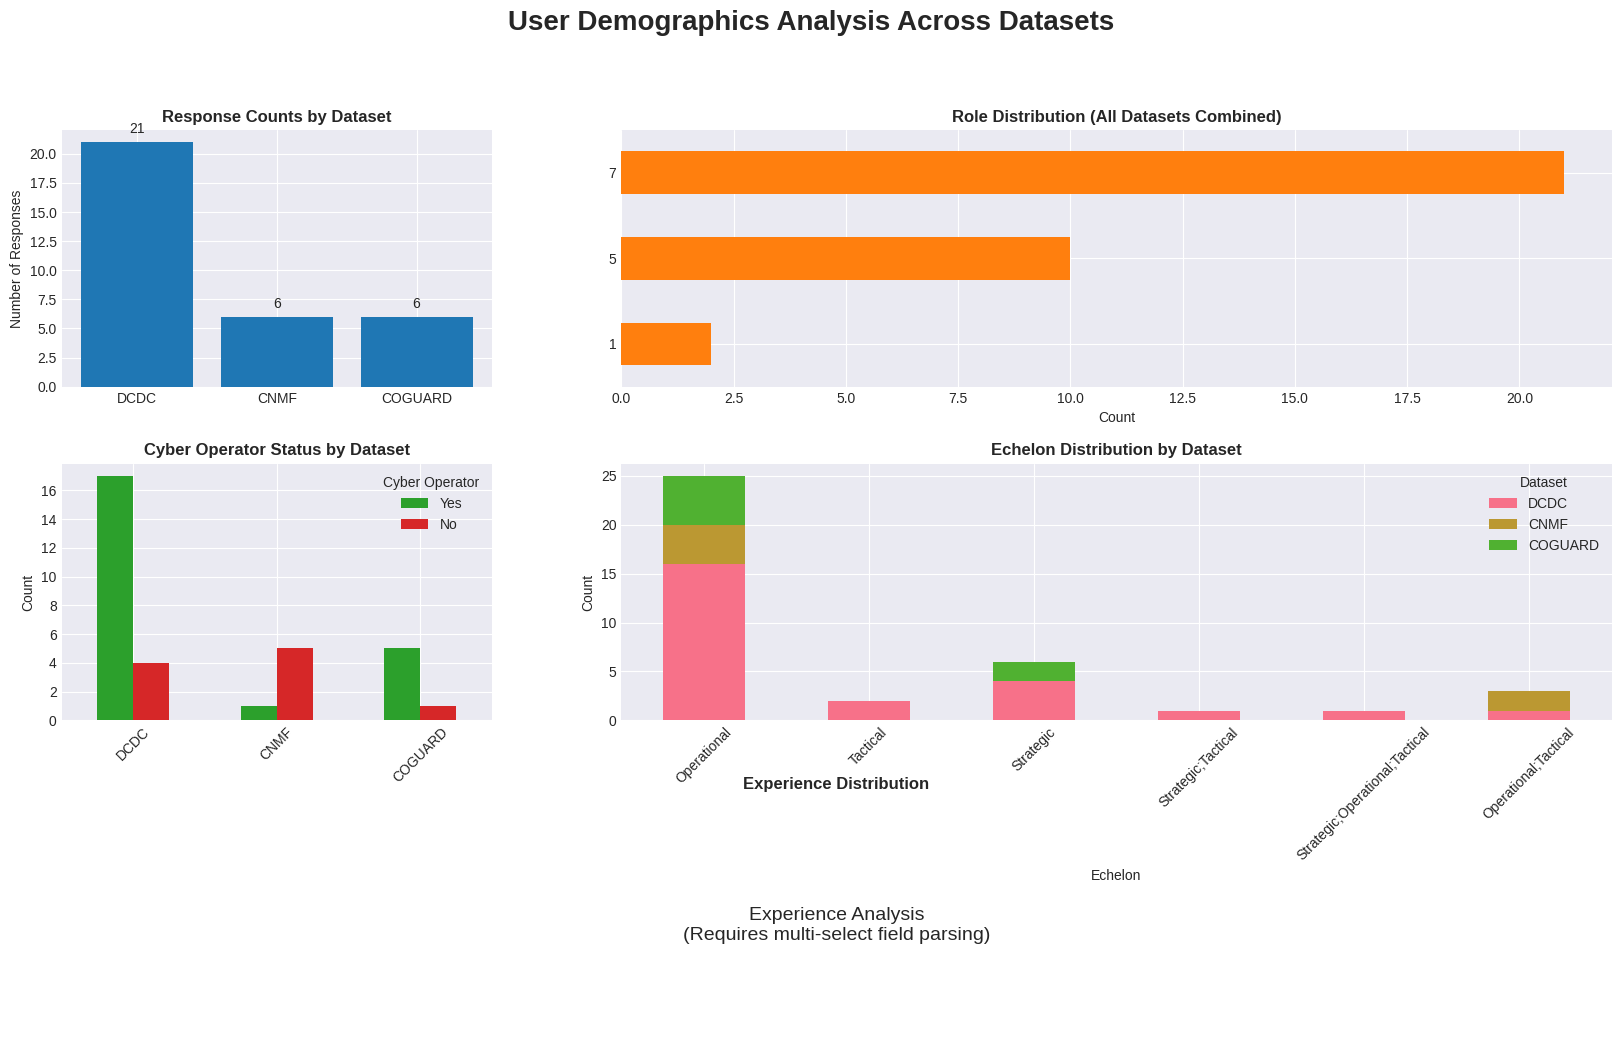

In [12]:
# Create demographic visualization dashboard
def create_demographics_dashboard(all_demographics, dataset_info):
    """Create a comprehensive demographics dashboard"""
    fig = plt.figure(figsize=(20, 12))
    fig.suptitle('User Demographics Analysis Across Datasets', fontsize=20, fontweight='bold')
    
    # Define subplot layout
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Response counts by dataset
    ax1 = fig.add_subplot(gs[0, 0])
    response_counts = [dataset_info[ds]['responses'] for ds in dataset_info]
    ax1.bar(dataset_info.keys(), response_counts, color=COLORS['primary'])
    ax1.set_title('Response Counts by Dataset', fontweight='bold')
    ax1.set_ylabel('Number of Responses')
    for i, v in enumerate(response_counts):
        ax1.text(i, v + 0.5, str(v), ha='center', va='bottom')
    
    # 2. Role distribution (combined)
    ax2 = fig.add_subplot(gs[0, 1:3])
    combined_roles = pd.Series()
    for dataset_name in all_demographics:
        if 'role' in all_demographics[dataset_name]:
            combined_roles = pd.concat([combined_roles, all_demographics[dataset_name]['role']])
    
    if not combined_roles.empty:
        role_counts = combined_roles.groupby(combined_roles).sum()
        role_counts.plot(kind='barh', ax=ax2, color=COLORS['secondary'])
        ax2.set_title('Role Distribution (All Datasets Combined)', fontweight='bold')
        ax2.set_xlabel('Count')
    
    # 3. Cyber Operator Status
    ax3 = fig.add_subplot(gs[1, 0])
    cyber_op_data = []
    labels = []
    for dataset_name in all_demographics:
        if 'cyber_operator' in all_demographics[dataset_name]:
            cyber_counts = all_demographics[dataset_name]['cyber_operator']
            # Get Yes/No counts
            yes_count = cyber_counts.get('Yes', 0)
            no_count = cyber_counts.get('No', 0)
            cyber_op_data.append([yes_count, no_count])
            labels.append(dataset_name)
    
    if cyber_op_data:
        cyber_df = pd.DataFrame(cyber_op_data, index=labels, columns=['Yes', 'No'])
        cyber_df.plot(kind='bar', ax=ax3, color=[COLORS['success'], COLORS['danger']])
        ax3.set_title('Cyber Operator Status by Dataset', fontweight='bold')
        ax3.set_ylabel('Count')
        ax3.legend(title='Cyber Operator')
        ax3.tick_params(axis='x', rotation=45)
    
    # 4. Echelon distribution
    ax4 = fig.add_subplot(gs[1, 1:3])
    echelon_counts = defaultdict(lambda: defaultdict(int))
    for dataset_name in all_demographics:
        if 'echelon' in all_demographics[dataset_name]:
            for echelon, count in all_demographics[dataset_name]['echelon'].items():
                # Skip if echelon is None or NaN
                if echelon is None or (isinstance(echelon, float) and pd.isna(echelon)):
                    continue
                    
                # Handle multi-select values (lists)
                if isinstance(echelon, list):
                    # Count this response for each selected echelon
                    for single_echelon in echelon:
                        if single_echelon is not None and not (isinstance(single_echelon, float) and pd.isna(single_echelon)):
                            echelon_counts[str(single_echelon)][dataset_name] += count
                else:
                    # Single value
                    echelon_counts[str(echelon)][dataset_name] = count
    
    if echelon_counts:
        echelon_df = pd.DataFrame(echelon_counts).T.fillna(0)
        echelon_df.plot(kind='bar', ax=ax4, stacked=True)
        ax4.set_title('Echelon Distribution by Dataset', fontweight='bold')
        ax4.set_xlabel('Echelon')
        ax4.set_ylabel('Count')
        ax4.legend(title='Dataset')
        ax4.tick_params(axis='x', rotation=45)
    
    # 5. Experience distribution
    ax5 = fig.add_subplot(gs[2, :])
    # This would show experience categories if the data structure supports it
    ax5.text(0.5, 0.5, 'Experience Analysis\n(Requires multi-select field parsing)', 
             ha='center', va='center', transform=ax5.transAxes, fontsize=14)
    ax5.set_title('Experience Distribution', fontweight='bold')
    ax5.axis('off')
    
    plt.tight_layout()
    return fig

# Create and save demographics dashboard
demo_fig = create_demographics_dashboard(all_demographics, dataset_info)
demo_fig.savefig(f'{output_dir}/demographics_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

Found 10 overall effectiveness rating fields


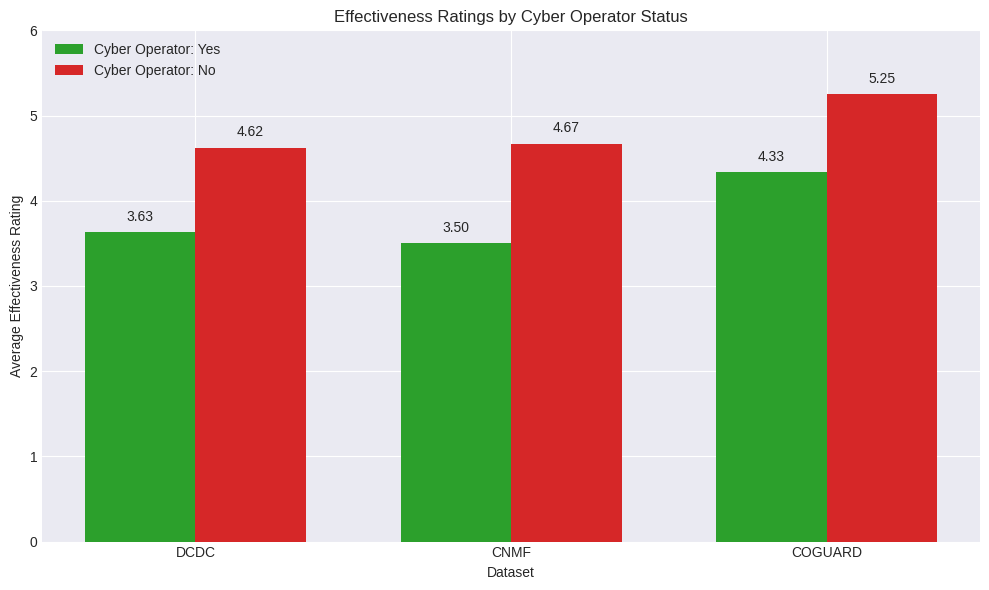

In [13]:
# Analyze correlation between demographics and ratings
def analyze_demographic_rating_correlation(df, demographic_field, rating_fields, dataset_name):
    """Analyze how demographics correlate with effectiveness ratings"""
    if demographic_field not in df.columns:
        return None
    
    # Get unique demographic values
    demo_values = df[demographic_field].dropna().unique()
    
    results = {}
    for demo_val in demo_values:
        mask = df[demographic_field] == demo_val
        subset = df[mask]
        
        ratings = []
        for field in rating_fields:
            if field in subset.columns:
                field_ratings = subset[field].map(rating_map).dropna()
                ratings.extend(field_ratings.tolist())
        
        if ratings:
            results[demo_val] = {
                'mean': np.mean(ratings),
                'std': np.std(ratings),
                'count': len(ratings),
                'n_users': len(subset)
            }
    
    return results

# Find overall effectiveness rating fields
overall_rating_fields = []
for dataset_name, processor in processors.items():
    for section, fields in processor.sections.items():
        for field in fields:
            if 'overall' in field.lower() and 'effectiveness' in field.lower():
                if field not in overall_rating_fields:
                    overall_rating_fields.append(field)

print(f"Found {len(overall_rating_fields)} overall effectiveness rating fields")

# Analyze correlations for cyber operator status
cyber_op_correlations = {}
for dataset_name, df in dataframes.items():
    correlation = analyze_demographic_rating_correlation(
        df, 
        demographic_fields['cyber_operator'],
        overall_rating_fields,
        dataset_name
    )
    if correlation:
        cyber_op_correlations[dataset_name] = correlation

# Visualize correlation results
if cyber_op_correlations:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Prepare data for plotting
    yes_means = []
    no_means = []
    labels = []
    
    for dataset, data in cyber_op_correlations.items():
        if 'Yes' in data:
            yes_means.append(data['Yes']['mean'])
        else:
            yes_means.append(0)
        
        if 'No' in data:
            no_means.append(data['No']['mean'])
        else:
            no_means.append(0)
        
        labels.append(dataset)
    
    x = np.arange(len(labels))
    width = 0.35
    
    ax.bar(x - width/2, yes_means, width, label='Cyber Operator: Yes', color=COLORS['success'])
    ax.bar(x + width/2, no_means, width, label='Cyber Operator: No', color=COLORS['danger'])
    
    ax.set_xlabel('Dataset')
    ax.set_ylabel('Average Effectiveness Rating')
    ax.set_title('Effectiveness Ratings by Cyber Operator Status')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    ax.set_ylim(0, 6)
    
    # Add value labels
    for i in range(len(labels)):
        if yes_means[i] > 0:
            ax.text(i - width/2, yes_means[i] + 0.1, f'{yes_means[i]:.2f}', 
                    ha='center', va='bottom')
        if no_means[i] > 0:
            ax.text(i + width/2, no_means[i] + 0.1, f'{no_means[i]:.2f}', 
                    ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/cyber_operator_rating_correlation.png', dpi=300)
    plt.show()

## 4. Sentiment Analysis of Feedback <a id='sentiment'></a>

Analyzing qualitative feedback using sentiment analysis and text mining techniques.

In [14]:
# Define text feedback fields with correct field names
text_feedback_fields = {
    'workarounds': 'mop_2_4_1.workarounds',
    'workaround_reasons': 'mop_2_4_1.workaround_reason',
    'workaround_details': 'mop_2_4_1.workaround_details',
    'training_observations': 'mos_3_2_1.training_additional_observations',
    'support_observations': 'mop_3_2_3.support_additional_observations',
    'critical_issues': 'overall_system_suitability_eval.critical_issues',
    'shout_outs': 'overall_system_suitability_eval.shout_outs',
    'final_thoughts': 'overall_system_suitability_eval.final_thoughts'
}

def extract_text_feedback(df, field_mapping):
    """Extract all text feedback from a dataframe"""
    feedback = {}
    
    for feedback_type, field in field_mapping.items():
        if field in df.columns:
            # Get non-null responses
            responses = df[field].dropna()
            # Filter out empty strings and standard non-responses
            responses = responses[~responses.isin(['', 'N/A', 'NA', 'None', 'none', 'n/a'])]
            # Also filter out very short responses (likely placeholders)
            responses = responses[responses.str.len() > 3]
            feedback[feedback_type] = responses.tolist()
        else:
            feedback[feedback_type] = []
    
    return feedback

# Extract feedback for all datasets
all_feedback = {}
for dataset_name, df in dataframes.items():
    all_feedback[dataset_name] = extract_text_feedback(df, text_feedback_fields)
    
    print(f"\n{dataset_name} Text Feedback Summary:")
    for feedback_type, responses in all_feedback[dataset_name].items():
        print(f"  {feedback_type}: {len(responses)} responses")


DCDC Text Feedback Summary:
  workarounds: 4 responses
  workaround_reasons: 0 responses
  workaround_details: 3 responses
  training_observations: 10 responses
  support_observations: 10 responses
  critical_issues: 14 responses
  shout_outs: 9 responses
  final_thoughts: 10 responses

CNMF Text Feedback Summary:
  workarounds: 3 responses
  workaround_reasons: 0 responses
  workaround_details: 3 responses
  training_observations: 2 responses
  support_observations: 1 responses
  critical_issues: 0 responses
  shout_outs: 0 responses
  final_thoughts: 0 responses

COGUARD Text Feedback Summary:
  workarounds: 2 responses
  workaround_reasons: 0 responses
  workaround_details: 1 responses
  training_observations: 3 responses
  support_observations: 2 responses
  critical_issues: 0 responses
  shout_outs: 1 responses
  final_thoughts: 1 responses


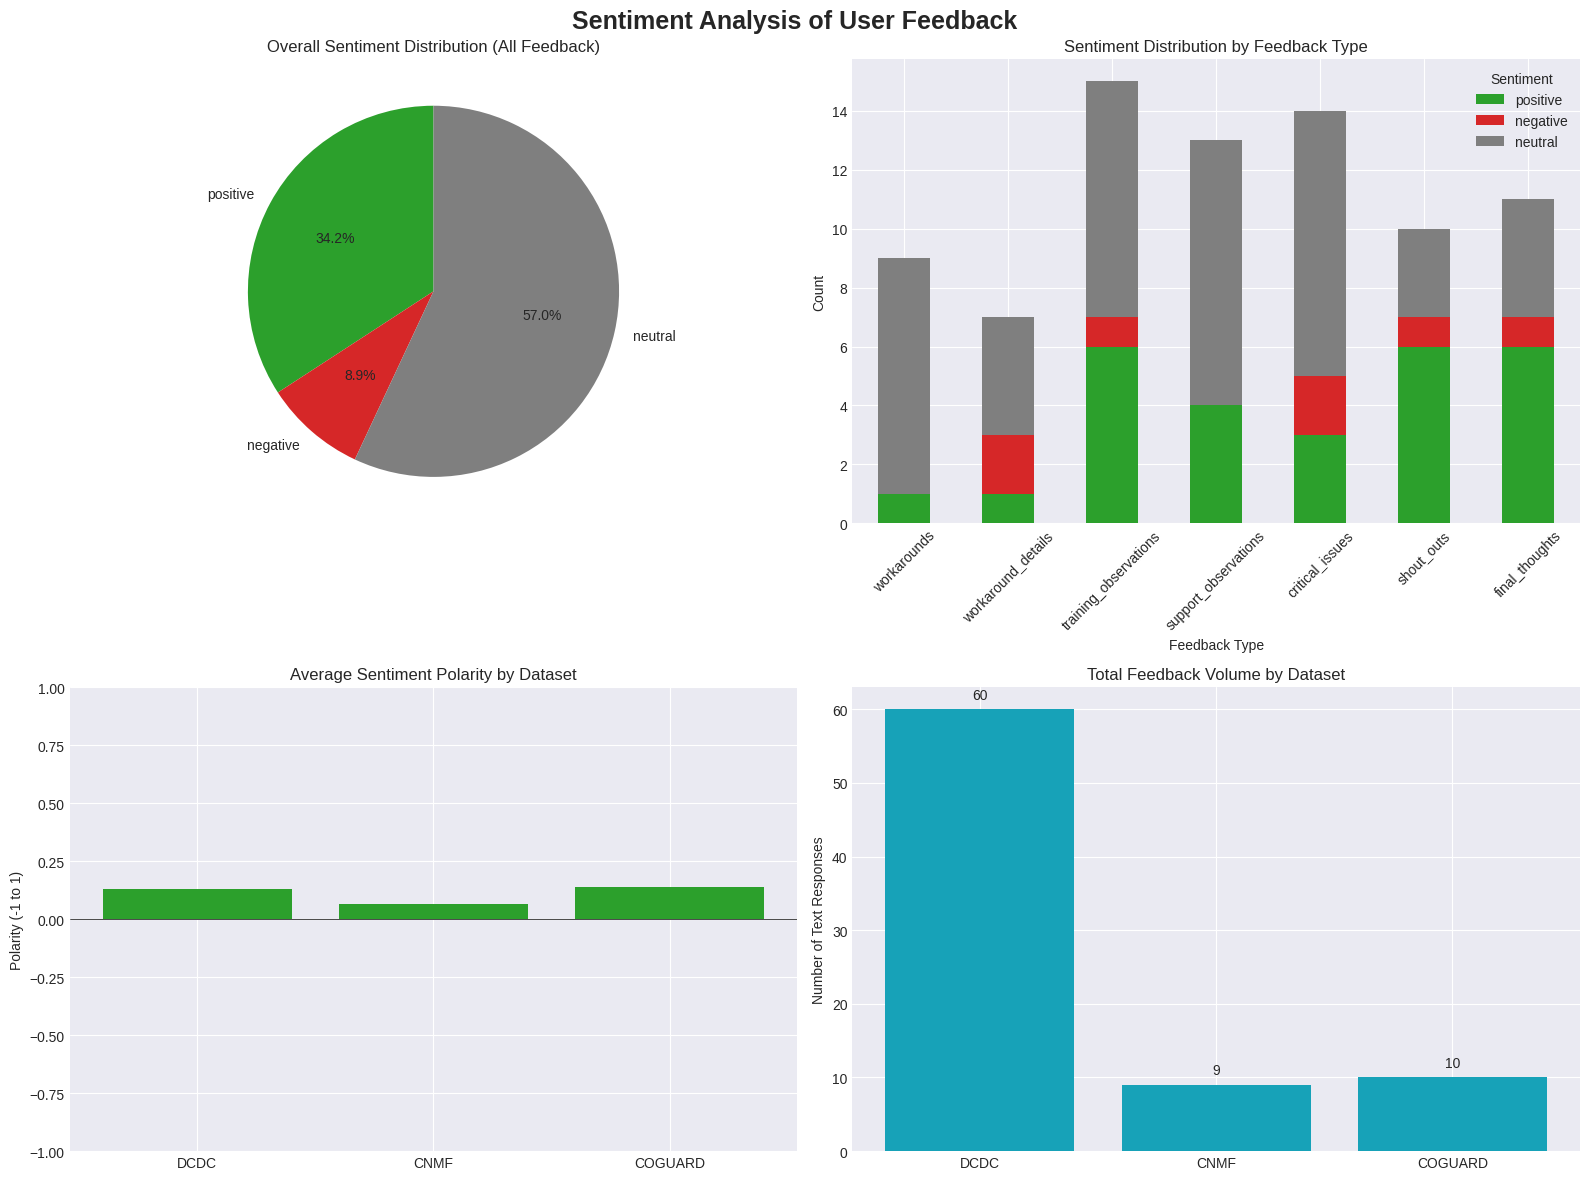

In [15]:
# Perform sentiment analysis
def analyze_sentiment(text):
    """Analyze sentiment of text using TextBlob"""
    try:
        blob = TextBlob(str(text))
        return {
            'polarity': blob.sentiment.polarity,  # -1 to 1
            'subjectivity': blob.sentiment.subjectivity,  # 0 to 1
            'sentiment': 'positive' if blob.sentiment.polarity > 0.1 else 
                        'negative' if blob.sentiment.polarity < -0.1 else 'neutral'
        }
    except:
        return {'polarity': 0, 'subjectivity': 0, 'sentiment': 'neutral'}

# Analyze sentiment for all feedback
sentiment_results = {}

for dataset_name, feedback_data in all_feedback.items():
    sentiment_results[dataset_name] = {}
    
    for feedback_type, responses in feedback_data.items():
        sentiments = [analyze_sentiment(response) for response in responses]
        
        if sentiments:
            sentiment_results[dataset_name][feedback_type] = {
                'responses': responses,
                'sentiments': sentiments,
                'avg_polarity': np.mean([s['polarity'] for s in sentiments]),
                'avg_subjectivity': np.mean([s['subjectivity'] for s in sentiments]),
                'positive_count': sum(1 for s in sentiments if s['sentiment'] == 'positive'),
                'negative_count': sum(1 for s in sentiments if s['sentiment'] == 'negative'),
                'neutral_count': sum(1 for s in sentiments if s['sentiment'] == 'neutral')
            }

# Visualize sentiment analysis results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Sentiment Analysis of User Feedback', fontsize=18, fontweight='bold')

# 1. Overall sentiment distribution
ax1 = axes[0, 0]
sentiment_counts = {'positive': 0, 'negative': 0, 'neutral': 0}
for dataset_results in sentiment_results.values():
    for feedback_results in dataset_results.values():
        sentiment_counts['positive'] += feedback_results.get('positive_count', 0)
        sentiment_counts['negative'] += feedback_results.get('negative_count', 0)
        sentiment_counts['neutral'] += feedback_results.get('neutral_count', 0)

if sum(sentiment_counts.values()) > 0:
    colors = [COLORS['success'], COLORS['danger'], COLORS['gray']]
    ax1.pie(sentiment_counts.values(), labels=sentiment_counts.keys(), autopct='%1.1f%%', 
            colors=colors, startangle=90)
    ax1.set_title('Overall Sentiment Distribution (All Feedback)')

# 2. Sentiment by feedback type
ax2 = axes[0, 1]
feedback_sentiment_data = defaultdict(lambda: {'positive': 0, 'negative': 0, 'neutral': 0})

for dataset_results in sentiment_results.values():
    for feedback_type, results in dataset_results.items():
        feedback_sentiment_data[feedback_type]['positive'] += results.get('positive_count', 0)
        feedback_sentiment_data[feedback_type]['negative'] += results.get('negative_count', 0)
        feedback_sentiment_data[feedback_type]['neutral'] += results.get('neutral_count', 0)

if feedback_sentiment_data:
    feedback_df = pd.DataFrame(feedback_sentiment_data).T
    feedback_df.plot(kind='bar', stacked=True, ax=ax2, 
                     color=[COLORS['success'], COLORS['danger'], COLORS['gray']])
    ax2.set_title('Sentiment Distribution by Feedback Type')
    ax2.set_xlabel('Feedback Type')
    ax2.set_ylabel('Count')
    ax2.legend(title='Sentiment')
    ax2.tick_params(axis='x', rotation=45)

# 3. Average polarity by dataset
ax3 = axes[1, 0]
dataset_polarities = {}
for dataset_name, results in sentiment_results.items():
    polarities = []
    for feedback_results in results.values():
        if 'avg_polarity' in feedback_results:
            polarities.append(feedback_results['avg_polarity'])
    if polarities:
        dataset_polarities[dataset_name] = np.mean(polarities)

if dataset_polarities:
    datasets = list(dataset_polarities.keys())
    polarities = list(dataset_polarities.values())
    colors = [COLORS['success'] if p > 0 else COLORS['danger'] for p in polarities]
    ax3.bar(datasets, polarities, color=colors)
    ax3.set_title('Average Sentiment Polarity by Dataset')
    ax3.set_ylabel('Polarity (-1 to 1)')
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax3.set_ylim(-1, 1)

# 4. Feedback volume by dataset
ax4 = axes[1, 1]
feedback_volumes = {}
for dataset_name, feedback in all_feedback.items():
    total_responses = sum(len(responses) for responses in feedback.values())
    feedback_volumes[dataset_name] = total_responses

if feedback_volumes:
    ax4.bar(feedback_volumes.keys(), feedback_volumes.values(), color=COLORS['info'])
    ax4.set_title('Total Feedback Volume by Dataset')
    ax4.set_ylabel('Number of Text Responses')
    for i, (dataset, count) in enumerate(feedback_volumes.items()):
        ax4.text(i, count + 1, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.savefig(f'{output_dir}/sentiment_analysis_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

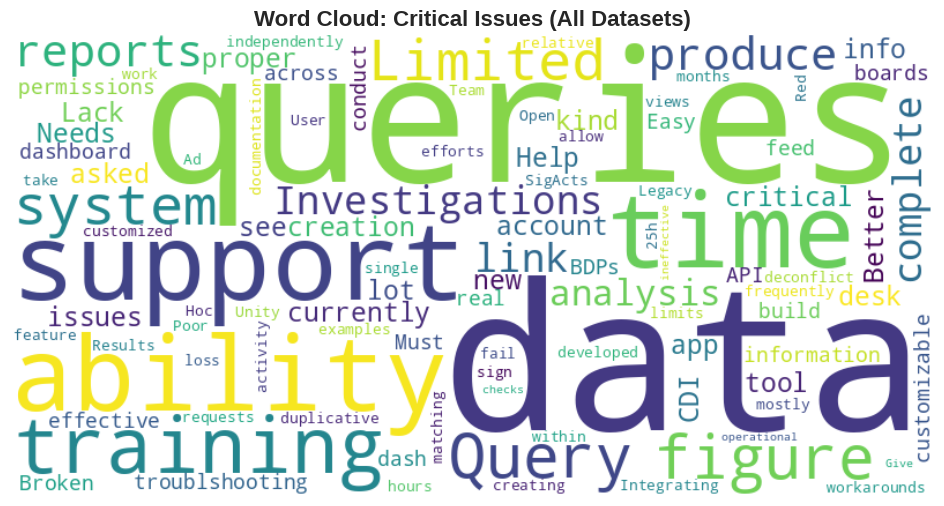

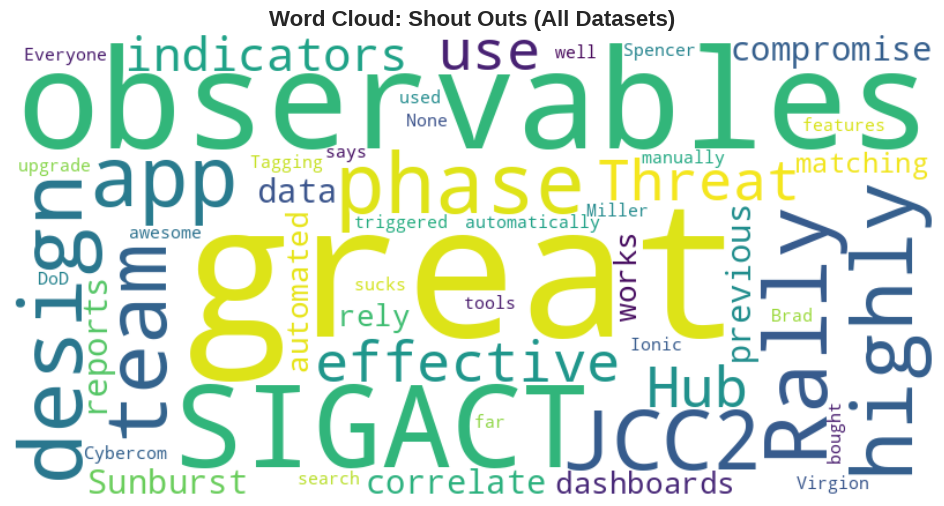

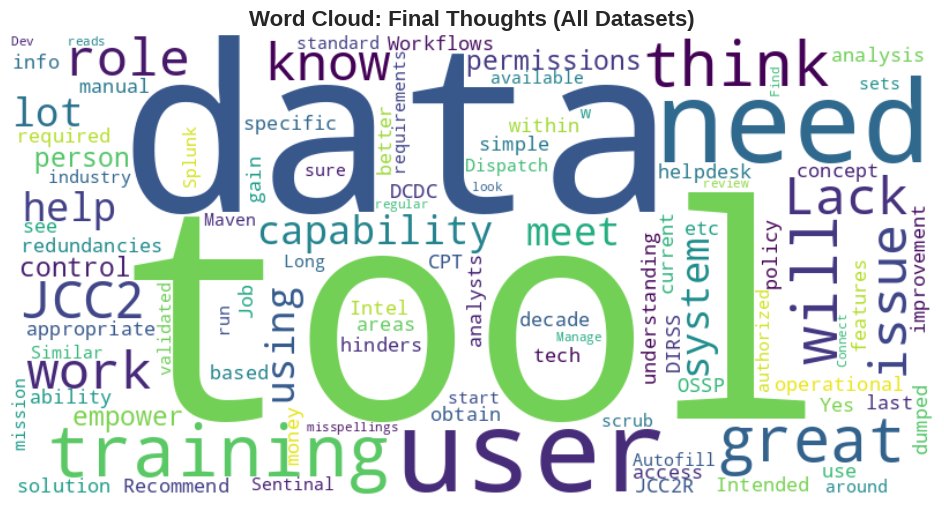

In [16]:
# Generate word clouds for key feedback categories
def generate_word_cloud(text_list, title):
    """Generate a word cloud from a list of text responses"""
    if not text_list:
        return None
    
    # Combine all text
    combined_text = ' '.join(str(text) for text in text_list)
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white',
                         colormap='viridis', max_words=100).generate(combined_text)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.axis('off')
    
    return fig

# Generate word clouds for critical feedback categories
critical_categories = ['critical_issues', 'shout_outs', 'final_thoughts']

for category in critical_categories:
    # Combine feedback from all datasets
    all_responses = []
    for dataset_feedback in all_feedback.values():
        if category in dataset_feedback:
            all_responses.extend(dataset_feedback[category])
    
    if all_responses:
        fig = generate_word_cloud(all_responses, 
                                 f'Word Cloud: {category.replace("_", " ").title()} (All Datasets)')
        if fig:
            fig.savefig(f'{output_dir}/wordcloud_{category}.png', dpi=300, bbox_inches='tight')
            plt.show()
            plt.close()

In [17]:
# Extract common themes from feedback
def extract_themes(text_list, n_themes=5):
    """Extract common themes from text feedback"""
    if not text_list:
        return []
    
    # Combine and tokenize
    combined_text = ' '.join(str(text).lower() for text in text_list)
    
    # Simple word frequency analysis for themes
    # Remove common words
    stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
                  'of', 'with', 'by', 'from', 'is', 'was', 'are', 'were', 'be', 'been',
                  'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'should',
                  'could', 'may', 'might', 'must', 'can', 'this', 'that', 'these', 'those',
                  'i', 'you', 'he', 'she', 'it', 'we', 'they', 'them', 'their', 'what',
                  'which', 'who', 'when', 'where', 'why', 'how', 'not', 'no', 'yes'}
    
    words = [word for word in combined_text.split() if len(word) > 3 and word not in stop_words]
    word_freq = Counter(words)
    
    return word_freq.most_common(n_themes)

# Extract themes for each feedback category
print("\nTop Themes by Feedback Category:")
print("=" * 60)

theme_summary = {}
for category in ['critical_issues', 'shout_outs', 'workarounds']:
    all_responses = []
    for dataset_feedback in all_feedback.values():
        if category in dataset_feedback:
            all_responses.extend(dataset_feedback[category])
    
    if all_responses:
        themes = extract_themes(all_responses, n_themes=10)
        theme_summary[category] = themes
        
        print(f"\n{category.replace('_', ' ').title()}:")
        for word, count in themes:
            print(f"  - {word}: {count} occurrences")


Top Themes by Feedback Category:

Critical Issues:
  - queries: 4 occurrences
  - 24/7: 3 occurrences
  - support: 3 occurrences
  - ability: 3 occurrences
  - data: 3 occurrences
  - figure: 2 occurrences
  - query: 2 occurrences
  - data.: 2 occurrences
  - limited: 2 occurrences
  - produce: 2 occurrences

Shout Outs:
  - observables: 3 occurrences
  - sigact/rally: 1 occurrences
  - design: 1 occurrences
  - phase: 1 occurrences
  - app,: 1 occurrences
  - jcc2: 1 occurrences
  - team: 1 occurrences
  - highly: 1 occurrences
  - effective.: 1 occurrences
  - threat: 1 occurrences

Workarounds:
  - mission: 3 occurrences
  - status: 2 occurrences
  - excel: 2 occurrences
  - rally: 1 occurrences
  - email: 1 occurrences
  - dao's: 1 occurrences
  - find: 1 occurrences
  - stand: 1 occurrences
  - investigation: 1 occurrences
  - constant: 1 occurrences


## 5. System Usability and Suitability Analysis <a id='usability'></a>

### ⚠️ CRITICAL DATA ISSUE: System Usability and Suitability Data Missing

**The System Usability and Suitability Analysis data is missing from ALL datasets (DCDC, CNMF, and COGUARD).**

This section was intended to analyze:
- System Usability Scale (SUS) scores
- System suitability factors (interoperability, information sharing, performance, access control)
- Overall usability metrics

**Possible Reasons for Missing Data:**
1. The questionnaire section was not completed by respondents
2. The data export process did not include these fields
3. The field names have changed in the questionnaire structure
4. These questions were added after the data collection period

**Recommendations:**
1. **Immediate Action**: Verify with the questionnaire administrators whether these sections were included in the deployed questionnaires
2. **Data Recovery**: Check if the raw response data contains these fields under different names
3. **Future Surveys**: Ensure these critical usability metrics are included and properly exported
4. **Alternative Analysis**: Consider using proxy metrics from other sections (training effectiveness, support ratings) as indirect usability indicators

The analysis below attempts to find any usability-related data that might exist under different field names.

### ⚠️ Important Note on Usability Scoring

The JCC2 questionnaire has a **critical data collection error** for the System Usability Scale (SUS) items:

- **Expected Response Scale**: Agreement scale (Strongly Disagree → Strongly Agree)
- **Actual Response Scale**: Effectiveness scale (Completely Ineffective → Completely Effective)

This makes standard SUS scoring invalid. Instead, we calculate a **"Usability Effectiveness Score"** that:
- Uses the effectiveness ratings as provided
- Reverses negative items (e.g., "unnecessarily complex")
- Converts to a 0-100 scale for comparison
- Should NOT be compared to standard SUS benchmarks

**Recommendation**: Future questionnaires should use the correct agreement scale for SUS items to enable valid SUS scoring.

In [18]:
# First, let's check what usability and suitability fields actually exist in the data
print("Searching for usability and suitability fields in the data...")

# Check for any fields containing 'usability' or 'suitability'
for dataset_name, df in dataframes.items():
    print(f"\n{dataset_name} Dataset:")
    
    # Find fields with 'usability' in the name
    usability_fields_found = [col for col in df.columns if 'usability' in col.lower()]
    print(f"  Usability fields found: {len(usability_fields_found)}")
    if usability_fields_found:
        for field in usability_fields_found[:10]:  # Show first 10
            print(f"    - {field}")
    
    # Find fields with 'suitability' in the name
    suitability_fields_found = [col for col in df.columns if 'suitability' in col.lower()]
    print(f"  Suitability fields found: {len(suitability_fields_found)}")
    if suitability_fields_found:
        for field in suitability_fields_found[:10]:  # Show first 10
            print(f"    - {field}")
    
    # Also check for 'overall_system' fields
    overall_system_fields = [col for col in df.columns if 'overall_system' in col.lower()]
    print(f"  Overall system fields found: {len(overall_system_fields)}")
    if overall_system_fields:
        for field in overall_system_fields[:10]:  # Show first 10
            print(f"    - {field}")

# Define usability and suitability fields with correct names
usability_fields = {
    # System Usability Scale (SUS) items
    # NOTE: The JCC2 questionnaire incorrectly uses effectiveness ratings instead of agreement scales
    # This makes standard SUS scoring invalid
    'like_to_use': 'overall_system_usability.like_to_use',
    'unnecessarily_complex': 'overall_system_usability.unnecessarily_complex',
    'easy_to_use': 'overall_system_usability.easy_to_use',
    'need_expert_support': 'overall_system_usability.need_expert_support',
    'well_integrated': 'overall_system_usability.functions_well_integrated',
    'quick_to_learn': 'overall_system_usability.quick_to_learn',
    'cumbersome': 'overall_system_usability.cumbersome_to_use',
    'confident': 'overall_system_usability.confident_using',
    'needed_to_learn': 'overall_system_usability.needed_to_learn_alot',
    'liked_interface': 'overall_system_usability.liked_interface'
}

# System suitability fields
suitability_fields = {
    'interoperability': 'overall_system_suitability_eval.interoperability_data_integration',
    'information_sharing': 'overall_system_suitability_eval.information_sharing_issues',
    'performance': 'overall_system_suitability_eval.performance_slowdowns',
    'access_control': 'overall_system_suitability_eval.access_control_permissions'
}

# Let's check if these specific fields exist
print("\n" + "="*60)
print("Checking for expected usability fields:")
for name, field in usability_fields.items():
    exists_in_any = any(field in df.columns for df in dataframes.values())
    print(f"  {name} ({field}): {'✓ Found' if exists_in_any else '✗ Not found'}")

print("\nChecking for expected suitability fields:")
for name, field in suitability_fields.items():
    exists_in_any = any(field in df.columns for df in dataframes.values())
    print(f"  {name} ({field}): {'✓ Found' if exists_in_any else '✗ Not found'}")

# Analyze usability for each dataset
def analyze_usability(df, dataset_name):
    """Analyze system usability and suitability metrics"""
    results = {}
    
    print(f"\n⚠️  WARNING: The JCC2 questionnaire uses effectiveness ratings (Completely Ineffective to Completely Effective)")
    print(f"   instead of agreement scales for SUS items. This makes standard SUS scoring invalid.")
    print(f"   Computing an adapted 'Usability Effectiveness Score' instead.\n")
    
    # Calculate Usability Effectiveness Score (NOT standard SUS)
    # Since the data uses effectiveness ratings, we'll treat it as such
    usability_ratings = []
    item_scores = {}
    
    for item_name, field in usability_fields.items():
        if field in df.columns:
            # Map effectiveness ratings to numeric values
            scores = df[field].map(rating_map).dropna()
            
            if len(scores) > 0:
                # For usability, some items should be reverse-scored
                # These are the "negative" items that indicate poor usability
                negative_items = ['unnecessarily_complex', 'need_expert_support', 
                                'cumbersome', 'needed_to_learn']
                
                if item_name in negative_items:
                    # For negative items, reverse the scale (7 - score to flip 1-6 scale)
                    adjusted_scores = 7 - scores
                else:
                    # For positive items, use as-is
                    adjusted_scores = scores
                
                item_scores[item_name] = {
                    'mean': adjusted_scores.mean(),
                    'original_mean': scores.mean(),
                    'count': len(adjusted_scores),
                    'reversed': item_name in negative_items
                }
                usability_ratings.extend(adjusted_scores.tolist())
    
    # Calculate overall usability effectiveness score
    # Convert from 1-6 scale to 0-100 scale
    if usability_ratings:
        mean_rating = np.mean(usability_ratings)
        # Convert 1-6 scale to 0-100: (score - 1) / 5 * 100
        usability_score = (mean_rating - 1) / 5 * 100
        
        results['usability_effectiveness_score'] = {
            'score': usability_score,
            'interpretation': 'Excellent' if usability_score >= 80 else 
                            'Good' if usability_score >= 60 else 
                            'Fair' if usability_score >= 40 else 'Poor',
            'n_items': len(item_scores),
            'n_responses': len(usability_ratings) // len(item_scores) if item_scores else 0,
            'item_scores': item_scores,
            'note': 'This is NOT a standard SUS score due to incorrect response scale'
        }
    
    # Analyze suitability factors
    for factor_name, field in suitability_fields.items():
        if field in df.columns:
            value_counts = df[field].value_counts()
            results[factor_name] = value_counts.to_dict()
    
    return results

# Analyze usability for all datasets
usability_results = {}
for dataset_name, df in dataframes.items():
    usability_results[dataset_name] = analyze_usability(df, dataset_name)
    
    print(f"\n{dataset_name} Usability Analysis:")
    if 'usability_effectiveness_score' in usability_results[dataset_name]:
        ue_data = usability_results[dataset_name]['usability_effectiveness_score']
        print(f"  Usability Effectiveness Score: {ue_data['score']:.1f}/100")
        print(f"  Interpretation: {ue_data['interpretation']}")
        print(f"  Based on {ue_data['n_responses']} responses")
        print(f"  Note: {ue_data['note']}")
    else:
        print(f"  ⚠️ No usability data found for this dataset")
    
    for metric, data in usability_results[dataset_name].items():
        if metric not in ['usability_effectiveness_score'] and isinstance(data, dict):
            print(f"  {metric}: {data}")

Searching for usability and suitability fields in the data...

DCDC Dataset:
  Usability fields found: 10
    - overall_system_usability.like_to_use
    - overall_system_usability.unnecessarily_complex
    - overall_system_usability.easy_to_use
    - overall_system_usability.need_expert_support
    - overall_system_usability.functions_well_integrated
    - overall_system_usability.quick_to_learn
    - overall_system_usability.cumbersome_to_use
    - overall_system_usability.confident_using
    - overall_system_usability.needed_to_learn_alot
    - overall_system_usability.liked_interface
  Suitability fields found: 22
    - overall_system_suitability_eval.internal_interop
    - overall_system_suitability_eval.internal_interop_details
    - overall_system_suitability_eval.external_integration
    - overall_system_suitability_eval.external_integ_details
    - overall_system_suitability_eval.legacy_compatibility
    - overall_system_suitability_eval.eval_legacy_compat_details
    - overall

[]


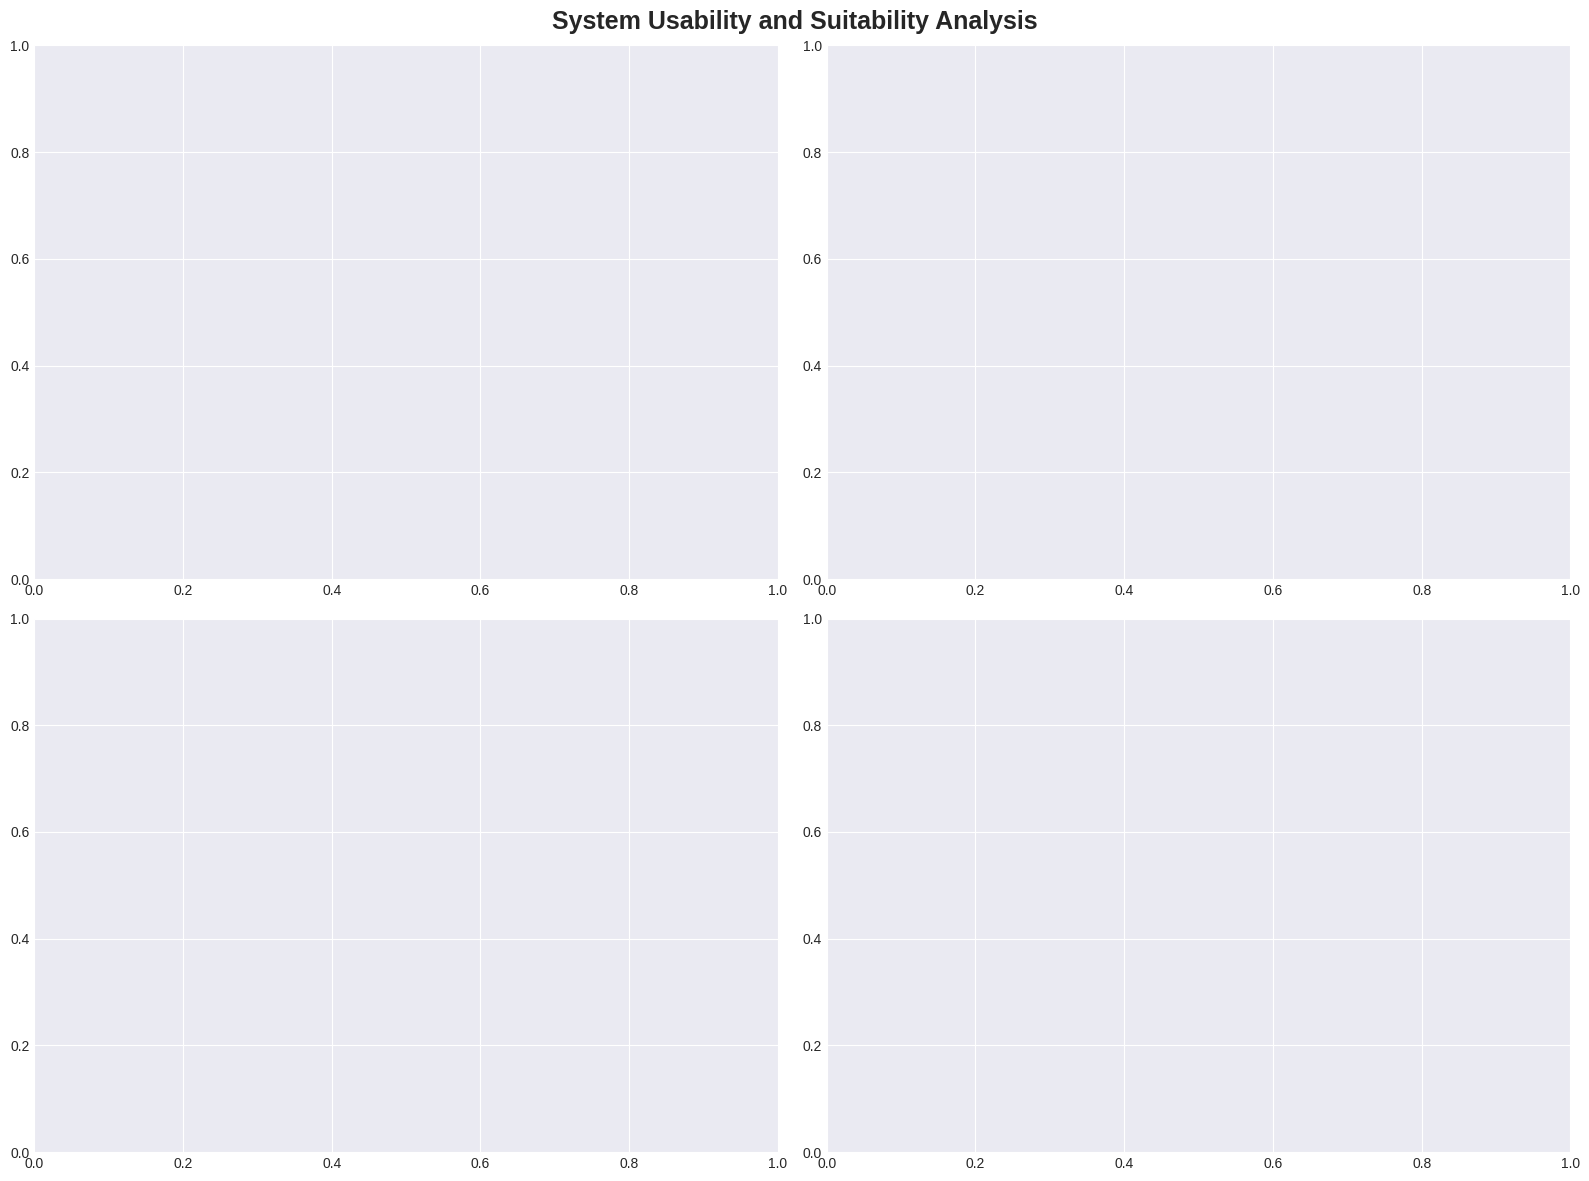

In [ ]:
# Create usability dashboard
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('System Usability and Suitability Analysis', fontsize=18, fontweight='bold')

# 1. Usability Effectiveness scores by dataset
ax1 = axes[0, 0]
ue_scores_data = {}
for dataset, results in usability_results.items():
    if 'usability_effectiveness_score' in results:
        ue_scores_data[dataset] = results['usability_effectiveness_score']['score']

if ue_scores_data:
    datasets = list(ue_scores_data.keys())
    scores = list(ue_scores_data.values())
    colors = [COLORS['success'] if s >= 60 else COLORS['warning'] if s >= 40 else COLORS['danger'] 
              for s in scores]
    
    bars = ax1.bar(datasets, scores, color=colors)
    ax1.set_title('Usability Effectiveness Scores*', fontweight='bold')
    ax1.set_ylabel('Score (0-100)')
    ax1.set_ylim(0, 100)
    
    # Add reference lines
    ax1.axhline(y=80, color='green', linestyle='--', alpha=0.5, label='Excellent (>80)')
    ax1.axhline(y=60, color='orange', linestyle='--', alpha=0.5, label='Good (>60)')
    ax1.axhline(y=40, color='red', linestyle='--', alpha=0.5, label='Fair (>40)')
    ax1.legend(loc='lower right', fontsize=9)
    
    # Add value labels and interpretation
    for i, (bar, score) in enumerate(zip(bars, scores)):
        interpretation = usability_results[datasets[i]]['usability_effectiveness_score']['interpretation']
        ax1.text(bar.get_x() + bar.get_width()/2, score + 1, 
                f'{score:.1f}\n({interpretation})', 
                ha='center', va='bottom', fontsize=10)
    
    # Add footnote about the scoring issue
    ax1.text(0.02, 0.02, '*Not standard SUS scores - uses effectiveness ratings', 
             transform=ax1.transAxes, fontsize=9, style='italic', color='gray')

# 2. Information sharing issues
ax2 = axes[0, 1]
info_sharing_data = []
labels = []

for dataset, results in usability_results.items():
    if 'information_sharing' in results:
        data = results['information_sharing']
        # Count different response types
        yes_count = sum(v for k, v in data.items() if k in ['Yes', 'Always', 'Often', 'Sometimes'])
        no_count = sum(v for k, v in data.items() if k in ['No', 'Never', 'Rarely'])
        
        if yes_count + no_count > 0:
            info_sharing_data.append([yes_count, no_count])
            labels.append(dataset)

if info_sharing_data:
    info_df = pd.DataFrame(info_sharing_data, index=labels, columns=['Issues', 'No Issues'])
    info_df.plot(kind='bar', ax=ax2, color=[COLORS['danger'], COLORS['success']], stacked=True)
    ax2.set_title('Information Sharing Issues by Dataset', fontweight='bold')
    ax2.set_ylabel('Number of Responses')
    ax2.legend(title='Response')
    ax2.tick_params(axis='x', rotation=45)

# 3. Performance issues
ax3 = axes[1, 0]
performance_data = []
labels = []

for dataset, results in usability_results.items():
    if 'performance' in results:
        data = results['performance']
        # Count responses indicating performance issues
        issue_responses = ['Yes', 'Always', 'Often', 'Sometimes', 'Frequently']
        no_issue_responses = ['No', 'Never', 'Rarely', 'Seldom']
        
        issues = sum(data.get(resp, 0) for resp in issue_responses)
        no_issues = sum(data.get(resp, 0) for resp in no_issue_responses)
        
        if issues + no_issues > 0:
            performance_data.append([issues, no_issues])
            labels.append(dataset)

if performance_data:
    perf_df = pd.DataFrame(performance_data, index=labels, columns=['Performance Issues', 'No Issues'])
    perf_df.plot(kind='bar', ax=ax3, color=[COLORS['warning'], COLORS['success']])
    ax3.set_title('Performance Issues by Dataset', fontweight='bold')
    ax3.set_ylabel('Number of Responses')
    ax3.legend()
    ax3.tick_params(axis='x', rotation=45)

# 4. Usability item breakdown (for the first dataset with data)
ax4 = axes[1, 1]
if ue_scores_data:
    # Get the first dataset with usability data
    first_dataset = list(ue_scores_data.keys())[0]
    item_scores = usability_results[first_dataset]['usability_effectiveness_score']['item_scores']
    
    if item_scores:
        items = list(item_scores.keys())
        scores = [item_scores[item]['mean'] for item in items]
        reversed_items = [item_scores[item]['reversed'] for item in items]
        
        # Create horizontal bar chart with color coding
        y_pos = np.arange(len(items))
        bar_colors = [COLORS['warning'] if rev else COLORS['info'] for rev in reversed_items]
        bars = ax4.barh(y_pos, scores, color=bar_colors)
        
        ax4.set_yticks(y_pos)
        ax4.set_yticklabels([item.replace('_', ' ').title() for item in items])
        ax4.set_xlabel('Average Score (1-6 scale, adjusted)')
        ax4.set_title(f'Usability Item Breakdown - {first_dataset}', fontweight='bold')
        ax4.set_xlim(1, 6)
        
        # Add value labels
        for i, (bar, score) in enumerate(zip(bars, scores)):
            ax4.text(score + 0.05, bar.get_y() + bar.get_height()/2, 
                    f'{score:.2f}', va='center')
        
        # Add legend
        import matplotlib.patches as mpatches
        blue_patch = mpatches.Patch(color=COLORS['info'], label='Positive items')
        orange_patch = mpatches.Patch(color=COLORS['warning'], label='Negative items (reversed)')
        ax4.legend(handles=[blue_patch, orange_patch], loc='lower right', fontsize=9)

plt.tight_layout()
plt.savefig(f'{output_dir}/usability_suitability_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Training and Support Effectiveness <a id='training'></a>

Analyzing the effectiveness of training programs and support services.

In [20]:
# Define training and support fields with correct names
training_fields = {
    'initial_training': 'mos_3_2_1.initial_training',
    'training_format': 'mos_3_2_1.training_format',
    'supplemental_training': 'mos_3_2_1.supplemental_training',
    'request_training': 'mos_3_2_1.request_training',
    # Training effectiveness by application
    'training_rating_jcc2cyberops': 'mos_3_2_1.training_rating_jcc2cyberops',
    'training_rating_jcc2readiness': 'mos_3_2_1.training_rating_jcc2readiness',
    'training_rating_a2it': 'mos_3_2_1.training_rating_a2it',
    # Documentation fields
    'documentation_rating_jcc2cyberops': 'mos_3_2_2.documentation_rating_jcc2cyberops',
    'documentation_rating_jcc2readiness': 'mos_3_2_2.documentation_rating_jcc2readiness',
    'documentation_format': 'mos_3_2_2.documentation_format',
    'documentation_meets_needs': 'mos_3_2_2.documentation_meets_needs',
    # Support fields
    'support_ticket_submission_jcc2cyberops': 'mop_3_2_3.ticket_submission_jcc2cyberops',
    'support_ticket_confirmation_jcc2cyberops': 'mop_3_2_3.ticket_confirmation_jcc2cyberops',
    'support_issue_resolution_jcc2cyberops': 'mop_3_2_3.issue_resolution_jcc2cyberops',
    'support_responsiveness_jcc2cyberops': 'mop_3_2_3.responsiveness_jcc2cyberops',
    'support_rating_jcc2cyberops': 'mop_3_2_3.support_rating_jcc2cyberops'
}

def analyze_training_support(df, dataset_name):
    """Analyze training and support effectiveness"""
    results = {}
    
    # Training received
    if training_fields['initial_training'] in df.columns:
        training_counts = df[training_fields['initial_training']].value_counts()
        results['training_received'] = training_counts.to_dict()
    
    # Training format - handle multi-select fields
    if training_fields['training_format'] in df.columns:
        format_data = df[training_fields['training_format']]
        
        # Check if it's a multi-select field (contains lists)
        if format_data.apply(lambda x: isinstance(x, list)).any():
            # Count occurrences of each format across all responses
            format_counts = {}
            for formats in format_data.dropna():
                if isinstance(formats, list):
                    for fmt in formats:
                        format_counts[fmt] = format_counts.get(fmt, 0) + 1
                else:
                    # Single value
                    format_counts[formats] = format_counts.get(formats, 0) + 1
            results['training_format'] = format_counts
        else:
            # Single-select field
            format_counts = format_data.value_counts()
            results['training_format'] = format_counts.to_dict()
    
    # Want more training
    if training_fields['request_training'] in df.columns:
        request_counts = df[training_fields['request_training']].value_counts()
        results['want_more_training'] = request_counts.to_dict()
    
    # Aggregate training effectiveness across applications
    training_ratings = []
    for field_name, field in training_fields.items():
        if 'training_rating_' in field_name and field in df.columns:
            ratings = df[field].map(rating_map).dropna()
            training_ratings.extend(ratings.tolist())
    
    if training_ratings:
        results['training_effectiveness'] = {
            'mean': np.mean(training_ratings),
            'std': np.std(training_ratings),
            'count': len(training_ratings),
            'median': np.median(training_ratings)
        }
    
    # Aggregate documentation effectiveness
    doc_ratings = []
    for field_name, field in training_fields.items():
        if 'documentation_rating_' in field_name and field in df.columns:
            ratings = df[field].map(rating_map).dropna()
            doc_ratings.extend(ratings.tolist())
    
    if doc_ratings:
        results['documentation_effectiveness'] = {
            'mean': np.mean(doc_ratings),
            'std': np.std(doc_ratings),
            'count': len(doc_ratings),
            'median': np.median(doc_ratings)
        }
    
    # Aggregate support effectiveness
    support_ratings = []
    for field_name, field in training_fields.items():
        if 'support_rating_' in field_name and field in df.columns:
            ratings = df[field].map(rating_map).dropna()
            support_ratings.extend(ratings.tolist())
    
    if support_ratings:
        results['support_effectiveness'] = {
            'mean': np.mean(support_ratings),
            'std': np.std(support_ratings),
            'count': len(support_ratings),
            'median': np.median(support_ratings)
        }
    
    return results

# Analyze for all datasets
training_results = {}
for dataset_name, df in dataframes.items():
    training_results[dataset_name] = analyze_training_support(df, dataset_name)
    
    print(f"\n{dataset_name} Training & Support Analysis:")
    for metric, data in training_results[dataset_name].items():
        if isinstance(data, dict) and 'mean' in data:
            print(f"  {metric}: {data['mean']:.2f} (n={data['count']})")
        else:
            print(f"  {metric}: {data}")


DCDC Training & Support Analysis:
  training_received: {'Yes': 12, 'No': 9}
  training_format: {'On-The-Job Training': 15, 'On-The-Job Training;None': 1, 'Video-Based Training;On-The-Job Training': 1, 'Video-Based Training': 2, 'Instructor-Lead Training': 4}
  want_more_training: {'Yes': 15, 'No': 6}
  training_effectiveness: 3.00 (n=9)
  documentation_effectiveness: 2.14 (n=7)

CNMF Training & Support Analysis:
  training_received: {'Yes': 5, 'No': 1}
  training_format: {'On-The-Job Training': 5}
  want_more_training: {'No': 3, 'Yes': 3}
  training_effectiveness: 4.67 (n=6)
  documentation_effectiveness: 3.75 (n=4)

COGUARD Training & Support Analysis:
  training_received: {'No': 4, 'Yes': 2}
  training_format: {'On-The-Job Training': 2, 'Instructor-Lead Training': 1, 'Video-Based Training': 1}
  want_more_training: {'No': 3, 'Yes': 3}
  training_effectiveness: 5.00 (n=2)
  documentation_effectiveness: 4.33 (n=3)


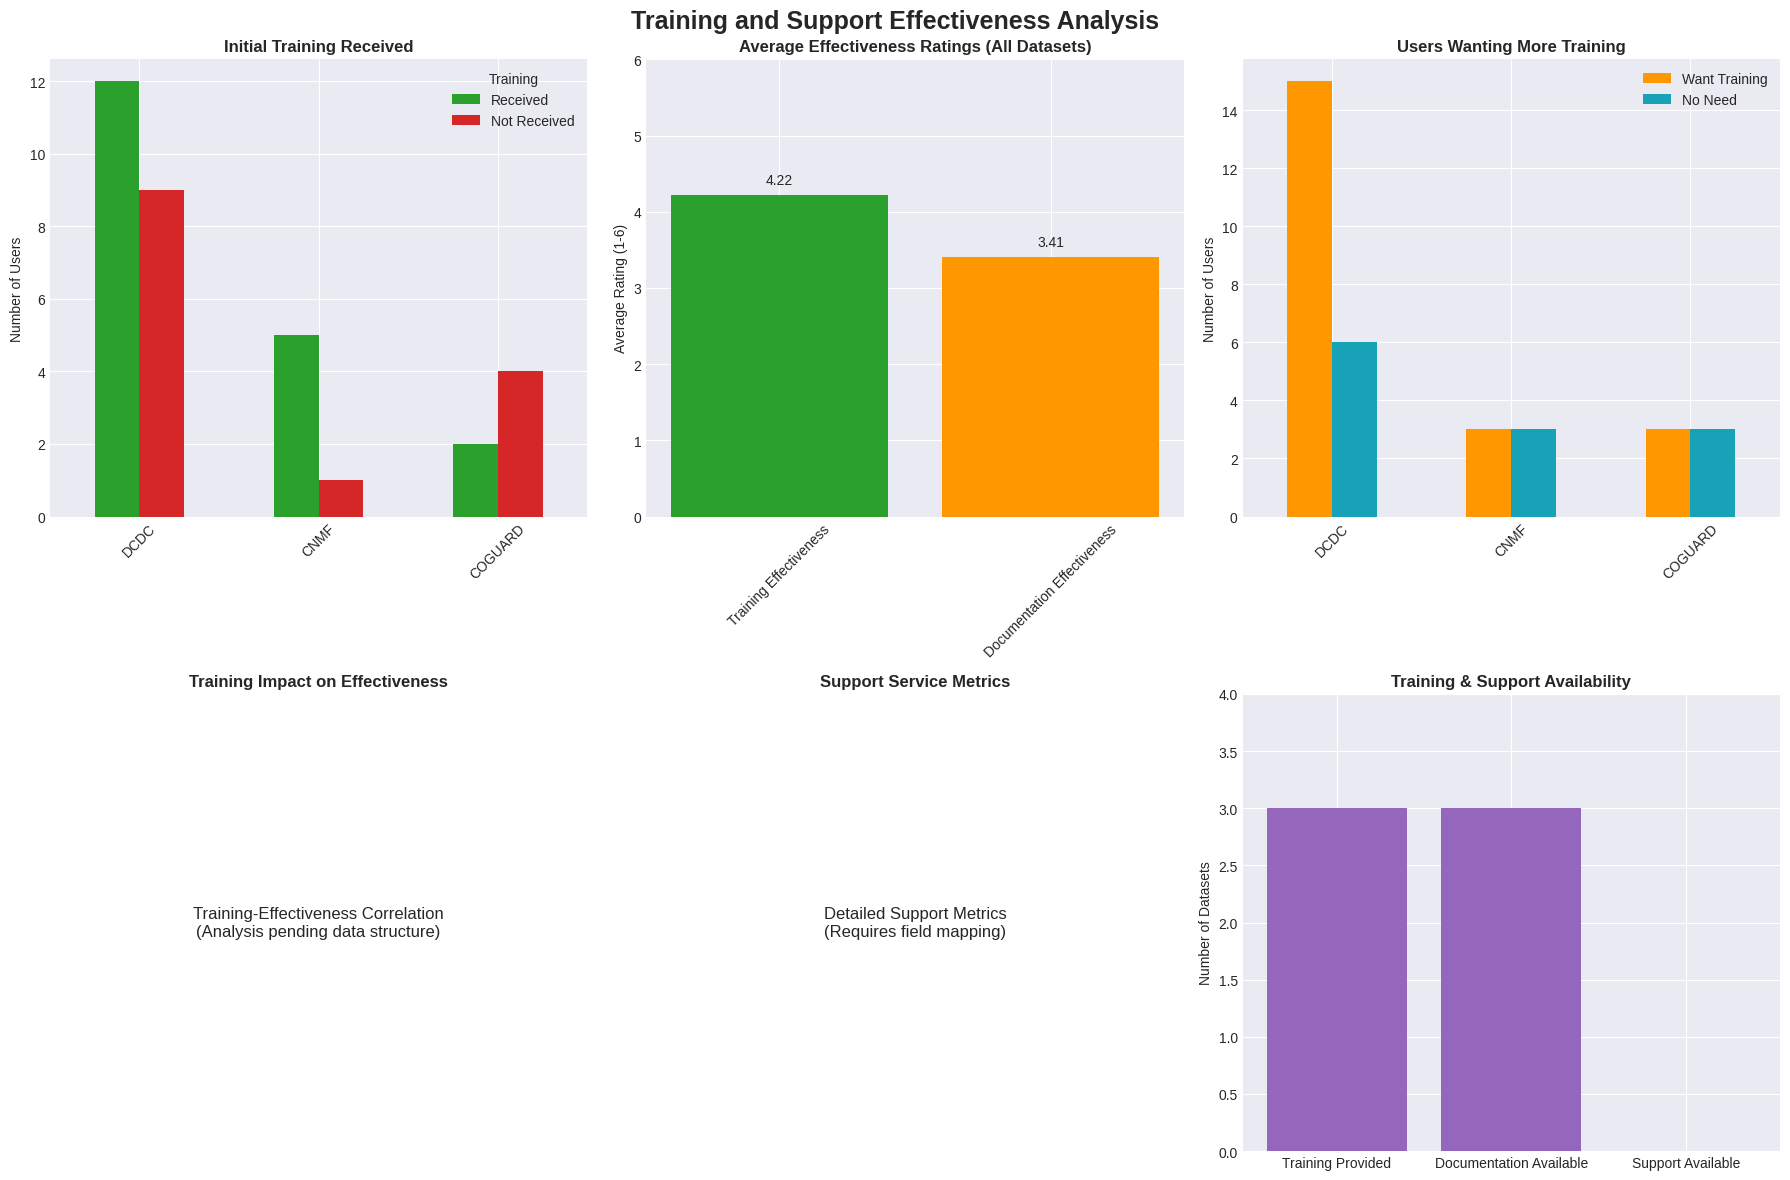

In [21]:
# Create training and support effectiveness dashboard
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Training and Support Effectiveness Analysis', fontsize=18, fontweight='bold')

# 1. Training received by dataset
ax1 = axes[0, 0]
training_received_data = []
labels = []

for dataset, results in training_results.items():
    if 'training_received' in results:
        data = results['training_received']
        yes_count = data.get('Yes', 0)
        no_count = data.get('No', 0)
        if yes_count + no_count > 0:
            training_received_data.append([yes_count, no_count])
            labels.append(dataset)

if training_received_data:
    training_df = pd.DataFrame(training_received_data, index=labels, columns=['Received', 'Not Received'])
    training_df.plot(kind='bar', ax=ax1, color=[COLORS['success'], COLORS['danger']])
    ax1.set_title('Initial Training Received', fontweight='bold')
    ax1.set_ylabel('Number of Users')
    ax1.legend(title='Training')
    ax1.tick_params(axis='x', rotation=45)

# 2. Training effectiveness ratings
ax2 = axes[0, 1]
effectiveness_scores = {}
categories = ['training_effectiveness', 'documentation_effectiveness', 'support_effectiveness']

for category in categories:
    scores = []
    for dataset, results in training_results.items():
        if category in results and 'mean' in results[category]:
            scores.append(results[category]['mean'])
    if scores:
        effectiveness_scores[category.replace('_', ' ').title()] = np.mean(scores)

if effectiveness_scores:
    categories = list(effectiveness_scores.keys())
    scores = list(effectiveness_scores.values())
    colors = [COLORS['success'] if s >= 4 else COLORS['warning'] if s >= 3 else COLORS['danger'] 
              for s in scores]
    
    ax2.bar(categories, scores, color=colors)
    ax2.set_title('Average Effectiveness Ratings (All Datasets)', fontweight='bold')
    ax2.set_ylabel('Average Rating (1-6)')
    ax2.set_ylim(0, 6)
    ax2.tick_params(axis='x', rotation=45)
    
    # Add value labels
    for i, score in enumerate(scores):
        ax2.text(i, score + 0.1, f'{score:.2f}', ha='center', va='bottom')

# 3. Users wanting more training
ax3 = axes[0, 2]
want_training_data = []
labels = []

for dataset, results in training_results.items():
    if 'want_more_training' in results:
        data = results['want_more_training']
        yes_count = data.get('Yes', 0)
        no_count = data.get('No', 0)
        if yes_count + no_count > 0:
            want_training_data.append([yes_count, no_count])
            labels.append(dataset)

if want_training_data:
    want_df = pd.DataFrame(want_training_data, index=labels, columns=['Want Training', 'No Need'])
    want_df.plot(kind='bar', ax=ax3, color=[COLORS['warning'], COLORS['info']])
    ax3.set_title('Users Wanting More Training', fontweight='bold')
    ax3.set_ylabel('Number of Users')
    ax3.legend()
    ax3.tick_params(axis='x', rotation=45)

# 4. Training vs effectiveness correlation
ax4 = axes[1, 0]
# This would show correlation between training received and effectiveness ratings
ax4.text(0.5, 0.5, 'Training-Effectiveness Correlation\n(Analysis pending data structure)', 
         ha='center', va='center', transform=ax4.transAxes, fontsize=12)
ax4.set_title('Training Impact on Effectiveness', fontweight='bold')
ax4.axis('off')

# 5. Support metrics comparison
ax5 = axes[1, 1]
support_metrics = ['Ticket Submission', 'Confirmation Receipt', 'Issue Resolution', 'Responsiveness']
# This would show detailed support metrics if available
ax5.text(0.5, 0.5, 'Detailed Support Metrics\n(Requires field mapping)', 
         ha='center', va='center', transform=ax5.transAxes, fontsize=12)
ax5.set_title('Support Service Metrics', fontweight='bold')
ax5.axis('off')

# 6. Overall training/support summary
ax6 = axes[1, 2]
summary_data = {
    'Training Provided': sum(1 for r in training_results.values() 
                            if r.get('training_received', {}).get('Yes', 0) > 0),
    'Documentation Available': sum(1 for r in training_results.values() 
                                  if 'documentation_effectiveness' in r),
    'Support Available': sum(1 for r in training_results.values() 
                           if 'support_effectiveness' in r)
}

ax6.bar(summary_data.keys(), summary_data.values(), color=COLORS['tertiary'])
ax6.set_title('Training & Support Availability', fontweight='bold')
ax6.set_ylabel('Number of Datasets')
ax6.set_ylim(0, max(len(dataframes), 4))

plt.tight_layout()
plt.savefig(f'{output_dir}/training_support_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Comparative Analysis Across Datasets <a id='comparative'></a>

Comprehensive comparison of all metrics across DCDC, CNMF, and COGUARD datasets.

In [22]:
# Create comprehensive comparison tables using great_tables
def create_dataset_comparison_table():
    """Create a comprehensive comparison table across all datasets"""
    
    # Prepare comparison data
    comparison_data = []
    
    for dataset_name in dataframes.keys():
        row = {
            'Dataset': dataset_name,
            'Responses': dataset_info[dataset_name]['responses'],
            'Date Range': dataset_info[dataset_name]['date_range'],
            'Avg App Rating': matrix_stats.get(dataset_name, {}).get('mean', 0),
            'Usability Score*': usability_results.get(dataset_name, {}).get('usability_effectiveness_score', {}).get('score', 0),
            'Training Effectiveness': training_results.get(dataset_name, {}).get('training_effectiveness', {}).get('mean', 0),
            'Support Effectiveness': training_results.get(dataset_name, {}).get('support_effectiveness', {}).get('mean', 0),
            'Text Feedback': sum(len(fb) for fb in all_feedback.get(dataset_name, {}).values())
        }
        comparison_data.append(row)
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Create great_table with fixed width for PowerPoint
    gt_comparison = (
        GT(comparison_df)
        .tab_header(
            title=md("**JCC2 Questionnaire Analysis - Dataset Comparison**"),
            subtitle=md("_Comprehensive metrics across all datasets_")
        )
        .fmt_number(
            columns=["Avg App Rating", "Training Effectiveness", "Support Effectiveness"],
            decimals=2
        )
        .fmt_number(
            columns=["Usability Score*"],
            decimals=1
        )
        .fmt_integer(
            columns=["Responses", "Text Feedback"]
        )
        .data_color(
            columns=["Avg App Rating", "Training Effectiveness", "Support Effectiveness"],
            palette=["#ff6666", "#ffcc00", "#ffff00", "#ccff00", "#66ff66"],
            domain=[1, 6],
            na_color="#d3d3d3"
        )
        .data_color(
            columns=["Usability Score*"],
            palette=["#ff6666", "#ffcc00", "#ffff00", "#ccff00", "#66ff66"],
            domain=[0, 100],
            na_color="#d3d3d3"
        )
        .tab_style(
            style=[style.text(weight="bold"), style.fill(color="#f0f0f0")],
            locations=loc.column_labels()
        )
        .tab_style(
            style=style.text(weight="bold"),
            locations=loc.body(columns=["Dataset"])
        )
        .tab_spanner(
            label=md("**Effectiveness Ratings**"),
            columns=["Avg App Rating", "Training Effectiveness", "Support Effectiveness"]
        )
        .tab_spanner(
            label=md("**Usability**"),
            columns=["Usability Score*"]
        )
        .tab_source_note(
            source_note=md("_Effectiveness ratings on 1-6 scale. *Usability score is NOT standard SUS (uses effectiveness scale). Higher values indicate better performance._")
        )
        .tab_options(
            table_width="800px",  # Fixed width suitable for PowerPoint
            table_font_size="12px",
            heading_title_font_size="18px",
            heading_subtitle_font_size="14px",
            source_notes_font_size="10px",
            data_row_padding="6px",
            column_labels_padding="8px"
        )
    )
    
    return gt_comparison

# Create and display comparison table
print("\nDataset Comparison Summary:")
comparison_table = create_dataset_comparison_table()
display(comparison_table)

# Save as image with DPI suitable for presentations
comparison_table.save(f'{output_dir}/dataset_comparison_table.png', scale=2)


Dataset Comparison Summary:


GT(_tbl_data=   Dataset  Responses                Date Range  Avg App Rating  \
0     DCDC         21  2025-06-23 to 2025-06-25        3.344186   
1     CNMF          6  2025-06-26 to 2025-06-26        4.657143   
2  COGUARD          6  2025-06-30 to 2025-06-30        5.050000   

   Usability Score*  Training Effectiveness  Support Effectiveness  \
0                 0                3.000000                      0   
1                 0                4.666667                      0   
2                 0                5.000000                      0   

   Text Feedback  
0             60  
1              9  
2             10  , _body=<great_tables._gt_data.Body object at 0x7268ab936ed0>, _boxhead=Boxhead([ColInfo(var='Dataset', type=<ColInfoTypeEnum.default: 1>, column_label='Dataset', column_align='left', column_width=None), ColInfo(var='Responses', type=<ColInfoTypeEnum.default: 1>, column_label='Responses', column_align='right', column_width=None), ColInfo(var='Date Range', type=<ColInfoTypeEnum.default: 1>, column_label='Date Range', column_align='left', column_width=None), ColInfo(var='Avg App Rating', type=<ColInfoTypeEnum.default: 1>, column_label='Avg App Rating', column_align='right', column_width=None), ColInfo(var='Training Effectiveness', type=<ColInfoTypeEnum.default: 1>, column_label='Training Effectiveness', column_align='right', column_width=None), ColInfo(var='Support Effectiveness', type=<ColInfoTypeEnum.default: 1>, column_label='Support Effectiveness', column_align='right', column_width=None), ColInfo(var='Usability Score*', type=<ColInfoTypeEnum.default: 1>, column_label='Usability Score*', column_align='right', column_width=None), ColInfo(var='Text Feedback', type=<ColInfoTypeEnum.default: 1>, column_label='Text Feedback', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7268ab830b50>, _spanners=Spanners([SpannerInfo(spanner_id='**Effectiveness Ratings**', spanner_level=0, spanner_label=Md(text='**Effectiveness Ratings**'), spanner_units=None, spanner_pattern=None, vars=['Avg App Rating', 'Training Effectiveness', 'Support Effectiveness'], built=None), SpannerInfo(spanner_id='**Usability**', spanner_level=0, spanner_label=Md(text='**Usability**'), spanner_units=None, spanner_pattern=None, vars=['Usability Score*'], built=None)]), _heading=Heading(title=Md(text='**JCC2 Questionnaire Analysis - Dataset Comparison**'), subtitle=Md(text='_Comprehensive metrics across all datasets_'), preheader=None), _stubhead=None, _source_notes=[Md(text='_Effectiveness ratings on 1-6 scale. *Usability score is NOT standard SUS (uses effectiveness scale). Higher values indicate better performance._')], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns='Avg App Rating', rows=[0], mask=None), grpname=None, colname='Avg App Rating', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#fff900')]), StyleInfo(locname=LocBody(columns='Avg App Rating', rows=[1], mask=None), grpname=None, colname='Avg App Rating', rownum=1, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#d0ff00')]), StyleInfo(locname=LocBody(columns='Avg App Rating', rows=[2], mask=None), grpname=None, colname='Avg App Rating', rownum=2, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#b4ff18')]), StyleInfo(locname=LocBody(columns='Training Effectiveness', rows=[0], mask=None), grpname=None, colname='Training Effectiveness', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, s

GT(_tbl_data=   Dataset  Responses                Date Range  Avg App Rating  \
0     DCDC         21  2025-06-23 to 2025-06-25        3.344186   
1     CNMF          6  2025-06-26 to 2025-06-26        4.657143   
2  COGUARD          6  2025-06-30 to 2025-06-30        5.050000   

   Usability Score*  Training Effectiveness  Support Effectiveness  \
0                 0                3.000000                      0   
1                 0                4.666667                      0   
2                 0                5.000000                      0   

   Text Feedback  
0             60  
1              9  
2             10  , _body=<great_tables._gt_data.Body object at 0x7268ab936ed0>, _boxhead=Boxhead([ColInfo(var='Dataset', type=<ColInfoTypeEnum.default: 1>, column_label='Dataset', column_align='left', column_width=None), ColInfo(var='Responses', type=<ColInfoTypeEnum.default: 1>, column_label='Responses', column_align='right', column_width=None), ColInfo(var='Date Range', type=<ColInfoTypeEnum.default: 1>, column_label='Date Range', column_align='left', column_width=None), ColInfo(var='Avg App Rating', type=<ColInfoTypeEnum.default: 1>, column_label='Avg App Rating', column_align='right', column_width=None), ColInfo(var='Training Effectiveness', type=<ColInfoTypeEnum.default: 1>, column_label='Training Effectiveness', column_align='right', column_width=None), ColInfo(var='Support Effectiveness', type=<ColInfoTypeEnum.default: 1>, column_label='Support Effectiveness', column_align='right', column_width=None), ColInfo(var='Usability Score*', type=<ColInfoTypeEnum.default: 1>, column_label='Usability Score*', column_align='right', column_width=None), ColInfo(var='Text Feedback', type=<ColInfoTypeEnum.default: 1>, column_label='Text Feedback', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7268ab830b50>, _spanners=Spanners([SpannerInfo(spanner_id='**Effectiveness Ratings**', spanner_level=0, spanner_label=Md(text='**Effectiveness Ratings**'), spanner_units=None, spanner_pattern=None, vars=['Avg App Rating', 'Training Effectiveness', 'Support Effectiveness'], built=None), SpannerInfo(spanner_id='**Usability**', spanner_level=0, spanner_label=Md(text='**Usability**'), spanner_units=None, spanner_pattern=None, vars=['Usability Score*'], built=None)]), _heading=Heading(title=Md(text='**JCC2 Questionnaire Analysis - Dataset Comparison**'), subtitle=Md(text='_Comprehensive metrics across all datasets_'), preheader=None), _stubhead=None, _source_notes=[Md(text='_Effectiveness ratings on 1-6 scale. *Usability score is NOT standard SUS (uses effectiveness scale). Higher values indicate better performance._')], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns='Avg App Rating', rows=[0], mask=None), grpname=None, colname='Avg App Rating', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#fff900')]), StyleInfo(locname=LocBody(columns='Avg App Rating', rows=[1], mask=None), grpname=None, colname='Avg App Rating', rownum=1, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#d0ff00')]), StyleInfo(locname=LocBody(columns='Avg App Rating', rows=[2], mask=None), grpname=None, colname='Avg App Rating', rownum=2, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#b4ff18')]), StyleInfo(locname=LocBody(columns='Training Effectiveness', rows=[0], mask=None), grpname=None, colname='Training Effectiveness', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, s

In [23]:
# Perform statistical comparisons between datasets
def perform_statistical_tests():
    """Perform statistical tests to identify significant differences between datasets"""
    
    print("\nStatistical Comparisons Between Datasets:")
    print("=" * 60)
    
    # Test 1: Overall effectiveness ratings
    effectiveness_by_dataset = {}
    for dataset_name, df in dataframes.items():
        # Collect all overall effectiveness ratings
        ratings = []
        for col in df.columns:
            if 'overall' in col.lower() and 'effectiveness' in col.lower():
                col_ratings = df[col].map(rating_map).dropna()
                ratings.extend(col_ratings.tolist())
        if ratings:
            effectiveness_by_dataset[dataset_name] = ratings
    
    # Perform ANOVA if we have data for all datasets
    if len(effectiveness_by_dataset) >= 2:
        f_stat, p_value = f_oneway(*effectiveness_by_dataset.values())
        print(f"\nOverall Effectiveness Ratings ANOVA:")
        print(f"  F-statistic: {f_stat:.4f}")
        print(f"  p-value: {p_value:.4f}")
        print(f"  Significant difference: {'Yes' if p_value < 0.05 else 'No'}")
    
    # Test 2: Cyber operator distribution
    cyber_op_distributions = []
    for dataset_name, df in dataframes.items():
        if demographic_fields['cyber_operator'] in df.columns:
            counts = df[demographic_fields['cyber_operator']].value_counts()
            cyber_op_distributions.append([counts.get('Yes', 0), counts.get('No', 0)])
    
    if len(cyber_op_distributions) >= 2:
        # Chi-square test for independence
        chi2, p_value, dof, expected = chi2_contingency(cyber_op_distributions)
        print(f"\nCyber Operator Distribution Chi-Square Test:")
        print(f"  Chi-square statistic: {chi2:.4f}")
        print(f"  p-value: {p_value:.4f}")
        print(f"  Significant difference: {'Yes' if p_value < 0.05 else 'No'}")
    
    return effectiveness_by_dataset

# Perform statistical tests
effectiveness_data = perform_statistical_tests()


Statistical Comparisons Between Datasets:

Overall Effectiveness Ratings ANOVA:
  F-statistic: 2.9978
  p-value: 0.0530
  Significant difference: No

Cyber Operator Distribution Chi-Square Test:
  Chi-square statistic: 9.7770
  p-value: 0.0075
  Significant difference: Yes


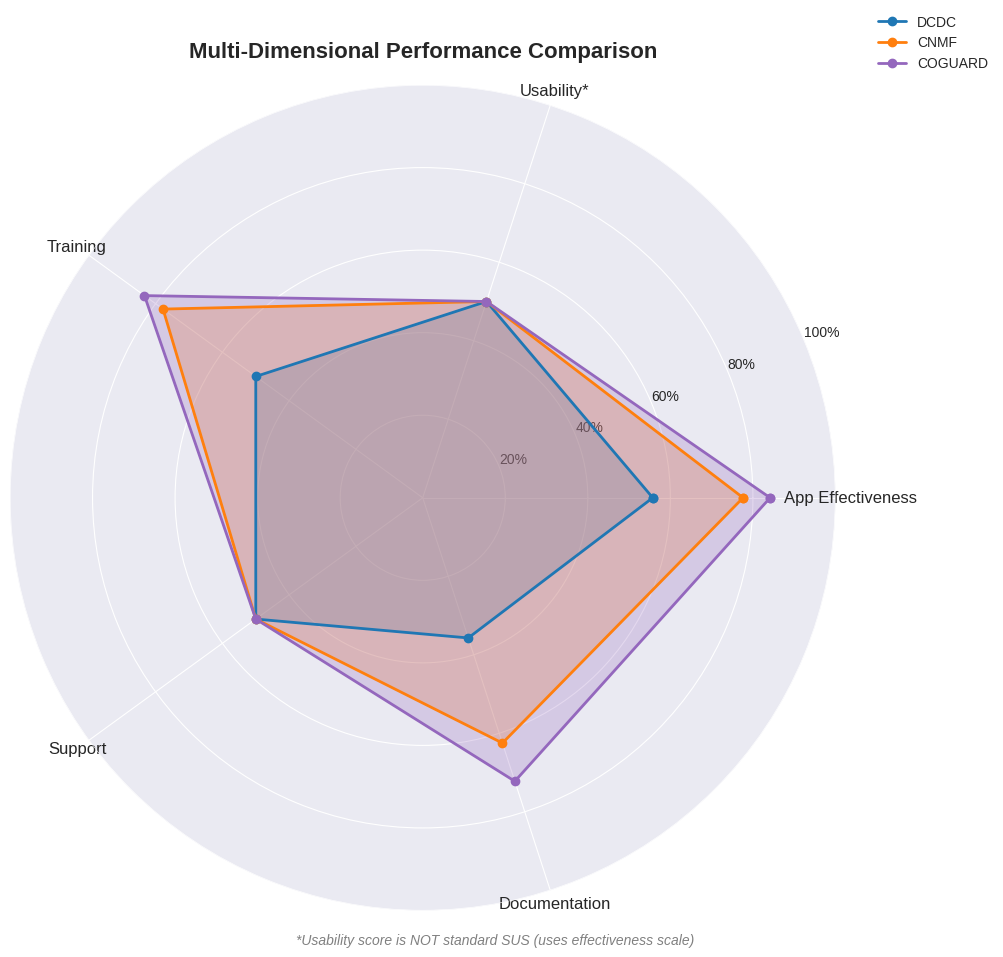

In [24]:
# Create radar chart for multi-dimensional comparison
def create_radar_chart():
    """Create a radar chart comparing key metrics across datasets"""
    
    # Define metrics for radar chart
    metrics = ['App Effectiveness', 'Usability*', 'Training', 'Support', 'Documentation']
    
    # Prepare data
    radar_data = {}
    for dataset_name in dataframes.keys():
        # Get values and convert to percentage scale (0-100)
        app_rating = matrix_stats.get(dataset_name, {}).get('mean', 3)
        usability_score = usability_results.get(dataset_name, {}).get('usability_effectiveness_score', {}).get('score', 50)
        training = training_results.get(dataset_name, {}).get('training_effectiveness', {}).get('mean', 3)
        support = training_results.get(dataset_name, {}).get('support_effectiveness', {}).get('mean', 3)
        documentation = training_results.get(dataset_name, {}).get('documentation_effectiveness', {}).get('mean', 3)
        
        values = [
            app_rating / 6 * 100,  # Convert 1-6 scale to percentage
            usability_score,  # Already in 0-100 scale
            training / 6 * 100,
            support / 6 * 100,
            documentation / 6 * 100
        ]
        radar_data[dataset_name] = values
    
    # Create radar chart
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    # Number of metrics
    num_vars = len(metrics)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Complete the circle
    
    # Plot data for each dataset
    colors = [COLORS['primary'], COLORS['secondary'], COLORS['tertiary']]
    for idx, (dataset_name, values) in enumerate(radar_data.items()):
        values += values[:1]  # Complete the circle
        ax.plot(angles, values, 'o-', linewidth=2, label=dataset_name, color=colors[idx % len(colors)])
        ax.fill(angles, values, alpha=0.25, color=colors[idx % len(colors)])
    
    # Set labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics, size=12)
    ax.set_ylim(0, 100)
    ax.set_yticks([20, 40, 60, 80, 100])
    ax.set_yticklabels(['20%', '40%', '60%', '80%', '100%'])
    ax.grid(True)
    
    # Add title and legend
    ax.set_title('Multi-Dimensional Performance Comparison', 
                 size=16, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
    
    # Add footnote about usability score
    fig.text(0.5, 0.02, '*Usability score is NOT standard SUS (uses effectiveness scale)', 
             ha='center', fontsize=10, style='italic', color='gray')
    
    plt.tight_layout()
    return fig

# Create and save radar chart
radar_fig = create_radar_chart()
radar_fig.savefig(f'{output_dir}/performance_radar_chart.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Key Insights and Recommendations <a id='insights'></a>

Synthesizing all analyses to provide actionable insights and recommendations.

In [25]:
# Generate key insights based on all analyses
def generate_insights():
    """Generate key insights from all analyses"""
    
    insights = {
        'top_performing_apps': [],
        'underperforming_apps': [],
        'critical_issues': [],
        'positive_highlights': [],
        'training_needs': [],
        'system_improvements': []
    }
    
    # 1. Application performance insights
    all_app_ratings = {}
    for dataset_name, matrix in all_matrices.items():
        for app in matrix.index:
            ratings = []
            for val in matrix.loc[app]:
                try:
                    ratings.append(float(val))
                except:
                    pass
            if ratings:
                if app not in all_app_ratings:
                    all_app_ratings[app] = []
                all_app_ratings[app].extend(ratings)
    
    # Calculate average ratings
    app_avg_ratings = {app: np.mean(ratings) for app, ratings in all_app_ratings.items() if ratings}
    sorted_apps = sorted(app_avg_ratings.items(), key=lambda x: x[1], reverse=True)
    
    # Top and bottom performers
    if sorted_apps:
        insights['top_performing_apps'] = [(app, rating) for app, rating in sorted_apps[:5] if rating >= 4.0]
        insights['underperforming_apps'] = [(app, rating) for app, rating in sorted_apps[-5:] if rating < 3.0]
    
    # 2. Critical issues from text feedback
    critical_themes = theme_summary.get('critical_issues', [])
    if critical_themes:
        insights['critical_issues'] = [theme[0] for theme in critical_themes[:5]]
    
    # 3. Positive highlights
    positive_themes = theme_summary.get('shout_outs', [])
    if positive_themes:
        insights['positive_highlights'] = [theme[0] for theme in positive_themes[:5]]
    
    # 4. Training needs
    for dataset, results in training_results.items():
        if results.get('want_more_training', {}).get('Yes', 0) > results.get('want_more_training', {}).get('No', 0):
            insights['training_needs'].append(f"High demand for training in {dataset}")
    
    # 5. System improvements needed
    for dataset, results in usability_results.items():
        if results.get('overall_usability', {}).get('mean', 0) < 3.5:
            insights['system_improvements'].append(f"Usability improvements needed for {dataset}")
    
    return insights

# Generate insights
key_insights = generate_insights()

# Display insights
print("\n" + "=" * 80)
print("KEY INSIGHTS AND RECOMMENDATIONS")
print("=" * 80)

print("\n1. TOP PERFORMING APPLICATIONS:")
for app, rating in key_insights['top_performing_apps']:
    print(f"   - {app}: {rating:.2f}/6.0")

print("\n2. APPLICATIONS NEEDING IMPROVEMENT:")
for app, rating in key_insights['underperforming_apps']:
    print(f"   - {app}: {rating:.2f}/6.0")

print("\n3. CRITICAL ISSUES TO ADDRESS:")
for issue in key_insights['critical_issues']:
    print(f"   - {issue}")

print("\n4. POSITIVE FEATURES TO MAINTAIN:")
for highlight in key_insights['positive_highlights']:
    print(f"   - {highlight}")

print("\n5. TRAINING RECOMMENDATIONS:")
for need in key_insights['training_needs']:
    print(f"   - {need}")

print("\n6. SYSTEM IMPROVEMENTS:")
for improvement in key_insights['system_improvements']:
    print(f"   - {improvement}")


KEY INSIGHTS AND RECOMMENDATIONS

1. TOP PERFORMING APPLICATIONS:
   - SigAct: 4.67/6.0
   - JCC2 Readiness: 4.26/6.0
   - Rally: 4.25/6.0

2. APPLICATIONS NEEDING IMPROVEMENT:
   - Threat Hub: 2.98/6.0
   - Codex: 2.97/6.0
   - Crucible: 2.92/6.0
   - Triage: 2.84/6.0
   - CAD: 1.50/6.0

3. CRITICAL ISSUES TO ADDRESS:
   - queries
   - 24/7
   - support
   - ability
   - data

4. POSITIVE FEATURES TO MAINTAIN:
   - observables
   - sigact/rally
   - design
   - phase
   - app,

5. TRAINING RECOMMENDATIONS:
   - High demand for training in DCDC

6. SYSTEM IMPROVEMENTS:
   - Usability improvements needed for DCDC
   - Usability improvements needed for CNMF
   - Usability improvements needed for COGUARD


In [26]:
# Create recommendations table using great_tables
def create_recommendations_table(insights):
    """Create a formatted recommendations table"""
    
    recommendations = [
        {
            'Priority': 'High',
            'Category': 'Application Performance',
            'Recommendation': f"Focus improvement efforts on {', '.join([app for app, _ in insights['underperforming_apps'][:3]])}",
            'Impact': 'Direct user productivity improvement'
        },
        {
            'Priority': 'High',
            'Category': 'Training',
            'Recommendation': 'Implement comprehensive training program based on user demand',
            'Impact': 'Improved user effectiveness and satisfaction'
        },
        {
            'Priority': 'Medium',
            'Category': 'System Usability',
            'Recommendation': 'Conduct usability review and implement UI/UX improvements',
            'Impact': 'Enhanced user experience and reduced support requests'
        },
        {
            'Priority': 'Medium',
            'Category': 'Documentation',
            'Recommendation': 'Update and expand documentation based on user feedback',
            'Impact': 'Reduced training burden and improved self-service'
        },
        {
            'Priority': 'Low',
            'Category': 'Feature Enhancement',
            'Recommendation': f"Expand successful features from {', '.join([app for app, _ in insights['top_performing_apps'][:2]])}",
            'Impact': 'Leverage existing strengths across platform'
        }
    ]
    
    rec_df = pd.DataFrame(recommendations)
    
    # Create great_table with fixed width for PowerPoint and corrected row selection
    gt_recommendations = (
        GT(rec_df)
        .tab_header(
            title=md("**Strategic Recommendations**"),
            subtitle=md("_Based on comprehensive analysis of user feedback and system performance_")
        )
        # Use lambda functions for row selection
        .tab_style(
            style=[style.fill(color="#ffcccc")],
            locations=loc.body(rows=lambda df: df['Priority'] == 'High')
        )
        .tab_style(
            style=[style.fill(color="#ffffcc")],
            locations=loc.body(rows=lambda df: df['Priority'] == 'Medium')
        )
        .tab_style(
            style=[style.fill(color="#ccffcc")],
            locations=loc.body(rows=lambda df: df['Priority'] == 'Low')
        )
        .tab_style(
            style=[style.text(weight="bold"), style.fill(color="#f0f0f0")],
            locations=loc.column_labels()
        )
        .tab_options(
            table_width="800px",  # Fixed width suitable for PowerPoint
            table_font_size="11px",  # Slightly smaller font for better fit
            heading_title_font_size="16px",
            heading_subtitle_font_size="12px",
            data_row_padding="8px",
            column_labels_padding="8px"
        )
    )
    
    return gt_recommendations

# Create and display recommendations
recommendations_table = create_recommendations_table(key_insights)
display(recommendations_table)
recommendations_table.save(f'{output_dir}/strategic_recommendations.png', scale=2)

GT(_tbl_data=  Priority                 Category  \
0     High  Application Performance   
1     High                 Training   
2   Medium         System Usability   
3   Medium            Documentation   
4      Low      Feature Enhancement   

                                      Recommendation  \
0  Focus improvement efforts on Threat Hub, Codex...   
1  Implement comprehensive training program based...   
2  Conduct usability review and implement UI/UX i...   
3  Update and expand documentation based on user ...   
4  Expand successful features from SigAct, JCC2 R...   

                                              Impact  
0               Direct user productivity improvement  
1       Improved user effectiveness and satisfaction  
2  Enhanced user experience and reduced support r...  
3  Reduced training burden and improved self-service  
4        Leverage existing strengths across platform  , _body=<great_tables._gt_data.Body object at 0x7268a93c2010>, _boxhead=Boxhead([ColInfo(var='Priority', type=<ColInfoTypeEnum.default: 1>, column_label='Priority', column_align='left', column_width=None), ColInfo(var='Category', type=<ColInfoTypeEnum.default: 1>, column_label='Category', column_align='left', column_width=None), ColInfo(var='Recommendation', type=<ColInfoTypeEnum.default: 1>, column_label='Recommendation', column_align='left', column_width=None), ColInfo(var='Impact', type=<ColInfoTypeEnum.default: 1>, column_label='Impact', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7268a8cbe090>, _spanners=Spanners([]), _heading=Heading(title=Md(text='**Strategic Recommendations**'), subtitle=Md(text='_Based on comprehensive analysis of user feedback and system performance_'), preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns=None, rows=<function create_recommendations_table.<locals>.<lambda> at 0x7268a81c0c20>, mask=None), grpname=None, colname='Priority', rownum=0, colnum=None, styles=[CellStyleFill(color='#ffcccc')]), StyleInfo(locname=LocBody(columns=None, rows=<function create_recommendations_table.<locals>.<lambda> at 0x7268a81c0c20>, mask=None), grpname=None, colname='Priority', rownum=1, colnum=None, styles=[CellStyleFill(color='#ffcccc')]), StyleInfo(locname=LocBody(columns=None, rows=<function create_recommendations_table.<locals>.<lambda> at 0x7268a81c0c20>, mask=None), grpname=None, colname='Category', rownum=0, colnum=None, styles=[CellStyleFill(color='#ffcccc')]), StyleInfo(locname=LocBody(columns=None, rows=<function create_recommendations_table.<locals>.<lambda> at 0x7268a81c0c20>, mask=None), grpname=None, colname='Category', rownum=1, colnum=None, styles=[CellStyleFill(color='#ffcccc')]), StyleInfo(locname=LocBody(columns=None, rows=<function create_recommendations_table.<locals>.<lambda> at 0x7268a81c0c20>, mask=None), grpname=None, colname='Recommendation', rownum=0, colnum=None, styles=[CellStyleFill(color='#ffcccc')]), StyleInfo(locname=LocBody(columns=None, rows=<function create_recommendations_table.<locals>.<lambda> at 0x7268a81c0c20>, mask=None), grpname=None, colname='Recommendation', rownum=1, colnum=None, styles=[CellStyleFill(color='#ffcccc')]), StyleInfo(locname=LocBody(columns=None, rows=<function create_recommendations_table.<locals>.<lambda> at 0x7268a81c0c20>, mask=None), grpname=None, colname='Impact', rownum=0, colnum=None, styles=[CellStyleFill(color='#ffcccc')]), StyleInfo(locname=LocBody(columns=None, rows=<function create_recommendations_table.<locals>.<lambda> at 0x7268a81c0c20>, mask=None), grpname=None, colname='Impact', rownum=1, colnum=None, styles=[CellStyleFill(color='#ffcccc')]), StyleInfo(locname=LocBody(columns=None, rows=<function create_recommendations_table.<locals>.<lambda> at 0x7268a81c1300>, mask=None), grpname=None, colname='Priority', rownum=2, colnum=None, styles=[CellStyleFill(color='#ffffcc')]), StyleInfo(locname=LocBody(columns=None, rows=<function create_recommen

GT(_tbl_data=  Priority                 Category  \
0     High  Application Performance   
1     High                 Training   
2   Medium         System Usability   
3   Medium            Documentation   
4      Low      Feature Enhancement   

                                      Recommendation  \
0  Focus improvement efforts on Threat Hub, Codex...   
1  Implement comprehensive training program based...   
2  Conduct usability review and implement UI/UX i...   
3  Update and expand documentation based on user ...   
4  Expand successful features from SigAct, JCC2 R...   

                                              Impact  
0               Direct user productivity improvement  
1       Improved user effectiveness and satisfaction  
2  Enhanced user experience and reduced support r...  
3  Reduced training burden and improved self-service  
4        Leverage existing strengths across platform  , _body=<great_tables._gt_data.Body object at 0x7268a93c2010>, _boxhead=Boxhead([ColInfo(var='Priority', type=<ColInfoTypeEnum.default: 1>, column_label='Priority', column_align='left', column_width=None), ColInfo(var='Category', type=<ColInfoTypeEnum.default: 1>, column_label='Category', column_align='left', column_width=None), ColInfo(var='Recommendation', type=<ColInfoTypeEnum.default: 1>, column_label='Recommendation', column_align='left', column_width=None), ColInfo(var='Impact', type=<ColInfoTypeEnum.default: 1>, column_label='Impact', column_align='left', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x7268a8cbe090>, _spanners=Spanners([]), _heading=Heading(title=Md(text='**Strategic Recommendations**'), subtitle=Md(text='_Based on comprehensive analysis of user feedback and system performance_'), preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns=None, rows=<function create_recommendations_table.<locals>.<lambda> at 0x7268a81c0c20>, mask=None), grpname=None, colname='Priority', rownum=0, colnum=None, styles=[CellStyleFill(color='#ffcccc')]), StyleInfo(locname=LocBody(columns=None, rows=<function create_recommendations_table.<locals>.<lambda> at 0x7268a81c0c20>, mask=None), grpname=None, colname='Priority', rownum=1, colnum=None, styles=[CellStyleFill(color='#ffcccc')]), StyleInfo(locname=LocBody(columns=None, rows=<function create_recommendations_table.<locals>.<lambda> at 0x7268a81c0c20>, mask=None), grpname=None, colname='Category', rownum=0, colnum=None, styles=[CellStyleFill(color='#ffcccc')]), StyleInfo(locname=LocBody(columns=None, rows=<function create_recommendations_table.<locals>.<lambda> at 0x7268a81c0c20>, mask=None), grpname=None, colname='Category', rownum=1, colnum=None, styles=[CellStyleFill(color='#ffcccc')]), StyleInfo(locname=LocBody(columns=None, rows=<function create_recommendations_table.<locals>.<lambda> at 0x7268a81c0c20>, mask=None), grpname=None, colname='Recommendation', rownum=0, colnum=None, styles=[CellStyleFill(color='#ffcccc')]), StyleInfo(locname=LocBody(columns=None, rows=<function create_recommendations_table.<locals>.<lambda> at 0x7268a81c0c20>, mask=None), grpname=None, colname='Recommendation', rownum=1, colnum=None, styles=[CellStyleFill(color='#ffcccc')]), StyleInfo(locname=LocBody(columns=None, rows=<function create_recommendations_table.<locals>.<lambda> at 0x7268a81c0c20>, mask=None), grpname=None, colname='Impact', rownum=0, colnum=None, styles=[CellStyleFill(color='#ffcccc')]), StyleInfo(locname=LocBody(columns=None, rows=<function create_recommendations_table.<locals>.<lambda> at 0x7268a81c0c20>, mask=None), grpname=None, colname='Impact', rownum=1, colnum=None, styles=[CellStyleFill(color='#ffcccc')]), StyleInfo(locname=LocBody(columns=None, rows=<function create_recommendations_table.<locals>.<lambda> at 0x7268a81c1300>, mask=None), grpname=None, colname='Priority', rownum=2, colnum=None, styles=[CellStyleFill(color='#ffffcc')]), StyleInfo(locname=LocBody(columns=None, rows=<function create_recommen

In [27]:
# Export comprehensive analysis summary
def export_master_analysis():
    """Export all analysis results to a comprehensive Excel file"""
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = f'{output_dir}/jcc2_master_analysis_{timestamp}.xlsx'
    
    # Prepare sheets for export
    sheets = {}
    
    # 1. Dataset Overview
    overview_data = []
    for dataset in dataframes.keys():
        overview_data.append({
            'Dataset': dataset,
            'Responses': dataset_info[dataset]['responses'],
            'Date Range': dataset_info[dataset]['date_range'],
            'Fields': dataset_info[dataset]['fields'],
            'Sections': dataset_info[dataset]['sections']
        })
    sheets['Dataset_Overview'] = pd.DataFrame(overview_data)
    
    # 2. Application Ratings
    for dataset_name, matrix in all_matrices.items():
        sheets[f'{dataset_name}_Ratings'] = matrix
    
    # 3. Demographics Summary
    demo_summary = []
    for dataset, demo_data in all_demographics.items():
        for demo_type, counts in demo_data.items():
            for value, count in counts.items():
                demo_summary.append({
                    'Dataset': dataset,
                    'Demographic': demo_type,
                    'Value': value,
                    'Count': count
                })
    if demo_summary:
        sheets['Demographics'] = pd.DataFrame(demo_summary)
    
    # 4. Sentiment Analysis
    sentiment_summary = []
    for dataset, results in sentiment_results.items():
        for feedback_type, data in results.items():
            sentiment_summary.append({
                'Dataset': dataset,
                'Feedback Type': feedback_type,
                'Total Responses': len(data.get('responses', [])),
                'Avg Polarity': data.get('avg_polarity', 0),
                'Positive': data.get('positive_count', 0),
                'Negative': data.get('negative_count', 0),
                'Neutral': data.get('neutral_count', 0)
            })
    if sentiment_summary:
        sheets['Sentiment_Analysis'] = pd.DataFrame(sentiment_summary)
    
    # 5. Key Insights
    insights_data = []
    for category, items in key_insights.items():
        if isinstance(items, list) and items:
            for item in items:
                if isinstance(item, tuple):
                    insights_data.append({
                        'Category': category.replace('_', ' ').title(),
                        'Item': item[0],
                        'Value': f"{item[1]:.2f}" if isinstance(item[1], (int, float)) else str(item[1])
                    })
                else:
                    insights_data.append({
                        'Category': category.replace('_', ' ').title(),
                        'Item': str(item),
                        'Value': ''
                    })
    if insights_data:
        sheets['Key_Insights'] = pd.DataFrame(insights_data)
    
    # Export to Excel
    export_to_excel(filename, sheets)
    
    print(f"\nMaster analysis exported to: {filename}")
    return filename

# Export the analysis
master_file = export_master_analysis()

# Create final summary report
summary_text = f"""
JCC2 QUESTIONNAIRE MASTER ANALYSIS SUMMARY
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

DATASETS ANALYZED:
- DCDC: {dataset_info['DCDC']['responses']} responses
- CNMF: {dataset_info['CNMF']['responses']} responses  
- COGUARD: {dataset_info['COGUARD']['responses']} responses
- Total: {sum(info['responses'] for info in dataset_info.values())} responses

KEY FINDINGS:
1. Average Application Effectiveness: {np.mean(list(matrix_stats[ds]['mean'] for ds in matrix_stats)):.2f}/6.0
2. Top Performing Applications: {', '.join([app for app, _ in key_insights['top_performing_apps'][:3]])}
3. Applications Needing Improvement: {', '.join([app for app, _ in key_insights['underperforming_apps'][:3]])}
4. Training Needed: {len([1 for r in training_results.values() if r.get('want_more_training', {}).get('Yes', 0) > 0])} datasets show demand
5. Text Feedback Analyzed: {sum(sum(len(fb) for fb in feedback.values()) for feedback in all_feedback.values())} responses

FILES GENERATED:
- Master Excel Analysis: {master_file}
- Visualization Dashboards: {len([f for f in os.listdir(output_dir) if f.endswith('.png')])} PNG files
- Great Tables Reports: Multiple formatted tables

RECOMMENDED NEXT STEPS:
1. Review underperforming applications for targeted improvements
2. Implement comprehensive training program
3. Address critical issues identified in user feedback
4. Enhance system usability based on user ratings
5. Leverage successful features from top-performing applications
"""

# Save summary report
summary_file = f'{output_dir}/analysis_summary.txt'
with open(summary_file, 'w') as f:
    f.write(summary_text)

print(summary_text)
print(f"\nAnalysis complete! All outputs saved to: {output_dir}/")

Exported to: jcc2_master_analysis_output/jcc2_master_analysis_20250803_211749.xlsx

Master analysis exported to: jcc2_master_analysis_output/jcc2_master_analysis_20250803_211749.xlsx

JCC2 QUESTIONNAIRE MASTER ANALYSIS SUMMARY
Generated: 2025-08-03 21:17:49

DATASETS ANALYZED:
- DCDC: 21 responses
- CNMF: 6 responses  
- COGUARD: 6 responses
- Total: 33 responses

KEY FINDINGS:
1. Average Application Effectiveness: 4.35/6.0
2. Top Performing Applications: SigAct, JCC2 Readiness, Rally
3. Applications Needing Improvement: Threat Hub, Codex, Crucible
4. Training Needed: 3 datasets show demand
5. Text Feedback Analyzed: 79 responses

FILES GENERATED:
- Master Excel Analysis: jcc2_master_analysis_output/jcc2_master_analysis_20250803_211749.xlsx
- Visualization Dashboards: 13 PNG files
- Great Tables Reports: Multiple formatted tables

RECOMMENDED NEXT STEPS:
1. Review underperforming applications for targeted improvements
2. Implement comprehensive training program
3. Address critical issu